# Проект

Необходимо разработать модель, предсказывающую закроется ли стартап или нет на основе данных о стартапах, функционировавших в период с 1970 по 2018 годы.

## 1. Загрузка библиотек

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re #регулярные выражения

from phik import phik_matrix
from phik.report import plot_correlation_matrix


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.set_theme(style="ticks")

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

!pip install shap -q
import shap
from shap import TreeExplainer


In [3]:
# Подавляем FutureWarning
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
# Константы
start_high = '\n\n\u001b[1m \033[4m'
end_high = '\033[0m \033[0m\n'
current_date = pd.Timestamp('2018-01-01')

## 2. Загрузка данных и изучение данных

## 2.1 Загрузка данных

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/correct-city/correct_city.csv
/kaggle/input/group-categories/group-categories.csv
/kaggle/input/startups-operations-close-predictions-m1-41-ds/kaggle_startups_train_28062024.csv
/kaggle/input/startups-operations-close-predictions-m1-41-ds/kaggle_startups_sample_submit_28062024.csv
/kaggle/input/startups-operations-close-predictions-m1-41-ds/kaggle_startups_test_28062024.csv


Поле category_list в исходном файле представляет собой список, разделенный символом | . Число уникальных категорий велико (~ 850). Было принято решение сгруппировать категории по направлениям (~50). Группировка проводилась вручную за пределами данной тетрадки. Результат был загружен в group-categories.csv

In [6]:
# Загрузка групп категорий
df_group_categories = pd.read_csv('/kaggle/input/group-categories/group-categories.csv', sep=';')
#category_list = df_group_categories['city'].unique().tolist()


In [7]:
# Загрузка данных и предварительная информация о датафрейме
def upload_data (_name, sep=';', decimal='.'):

#    df_category_list = pd.DataFrame(columns=['category', 'cat_count'])
    df = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m1-41-ds/' + _name, sep=',', decimal=decimal)

    # переименование столбцов
    df.columns = [re.sub(r'(?:<1^)(?=[A-Z])','_',i).replace(' ','_').lower() for i in df.columns]

# сделаем индексами идентификаторы клиентов    
    print (start_high, _name, end_high)
    print(start_high, 'Размер:', end_high, df.shape)
    print('\n',start_high, 'Head', end_high)
    display(df.head())
    print('\n',start_high, 'Info', end_high)
    df.info()
   
    return df

In [8]:
df_train = upload_data('kaggle_startups_train_28062024.csv', sep=',')



  kaggle_startups_train_28062024.csv  



  Размер:  
 (52516, 13)

 

  Head  



,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN



 

  Info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [9]:
df_test = upload_data('kaggle_startups_test_28062024.csv', sep=',')



  kaggle_startups_test_28062024.csv  



  Размер:  
 (13125, 11)

 

  Head  



,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209



 

  Info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


## 2.2 Подготовка полей типа datetime

In [10]:
# Преобразование полей дат
df_train['founded_at'] = pd.to_datetime(df_train['founded_at'])
df_train['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'])
df_train['last_funding_at'] = pd.to_datetime(df_train['last_funding_at'])
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'])
df_train['lifetime'] = (df_train['closed_at'] - df_train['founded_at']).dt.days

#df_test['founded_at'] = pd.to_datetime(df_test['founded_at'])
df_test['first_funding_at'] = pd.to_datetime(df_test['first_funding_at'])
df_test['last_funding_at'] = pd.to_datetime(df_test['last_funding_at'])


In [11]:
# Проверка согласованности 'status' и 'closed_at'
print('Работают и дата закрытия пустая:',((df_train['status'] == 'operating')&(df_train['closed_at'].isna())).sum()) 
print('Работают и дата закрытия не пустая:',((df_train['status'] == 'operating')&(~df_train['closed_at'].isna())).sum())
print('Не работают и дата закрытия пустая:',((df_train['status'] != 'operating')&(df_train['closed_at'].isna())).sum())
print('Не работают и дата закрытия не пустая:',((df_train['status'] != 'operating')&(~df_train['closed_at'].isna())).sum())

Работают и дата закрытия пустая: 47599
Работают и дата закрытия не пустая: 0
Не работают и дата закрытия пустая: 0
Не работают и дата закрытия не пустая: 4917


In [12]:
# Добавим колонку 'lifetime' в df_train
df_train['closed_at'] = df_train['closed_at'].fillna(current_date) # заменим пустые значения в 'closed_at' на текущую дату '2018-01-01'
df_train['lifetime'] = (df_train['closed_at'] - df_train['founded_at']).dt.days # создадим 'lifetime' с дельтой 'closed_at' - 'founded_at'

Для выявления потенциальной сезонности разделим даты первого и последнего раунда инвестирования на отдельные колонки для дня, месяца и года.

In [13]:
# создание колонок для дня, месяца и года первого и последнего раунда инвестирования
for df in (df_train, df_test):
    for f_date in ('first_funding_at', 'last_funding_at'):
        df[f_date +'_y'] = df['last_funding_at'].dt.year
        df[f_date +'_m'] = df['last_funding_at'].dt.month
        df[f_date +'_d'] = df['last_funding_at'].dt.day

Для проверки гипотезы о влиянии закроется стартап или нет даты последего раунда инвестирования, создадим колонку after_last_invest, содержащую дельту между датой закрытия или текущей датой и датой последего раунда инвестирования.

In [14]:
# Добавим колонку 'after_last_invest' в df_train и df_test
df_train['after_last_invest'] = (df_train['closed_at'] - df_train['last_funding_at']).dt.days # создадим 'lifetime' с дельтой 'closed_at'-'founded_at'
df_test['after_last_invest'] = (current_date - df_test['last_funding_at']).dt.days # создадим 'lifetime' с дельтой текущая дата '2018-01-01' - 'founded_at'
# df_train.head(20)

In [15]:
# Добавим колонку 'investtime' как дельту между первым и последним раундом инвестирования в df_train, df_test

for df in (df_train, df_test):
    df['investtime'] = (df['last_funding_at'] - df['first_funding_at']).dt.days # создадим 'investtime' с дельтой 'last_funding_at'-'first_funding_at'


## 2.3 Подготовка полей category и int

In [16]:
# Преобразование типов полей датафреймов
def change_data_type (df, excl_cols):

    # категорийные поля
    cat_cols = df.select_dtypes(exclude=['number','datetime64']).drop(columns=excl_cols).columns.tolist()
    if len(cat_cols) > 0: # есть поля типа "object"
        print(start_high, 'Категорийные поля:', end_high, cat_cols)
        for i in cat_cols:
            print('Поле:', i)
            display(df[i].value_counts()) # печать уникальных значений для выявления неявных дубликатов
            df[i] = df[i].astype('category')
        display(df[cat_cols].describe())
    
    # количественные поля
    
    qnt_cols = df.select_dtypes(include='number').columns.tolist()
    if len(qnt_cols) > 0: # есть поля типа "object"
        print(start_high, 'Количественные поля:', end_high, qnt_cols)
        display(df[qnt_cols].describe())

    
    return cat_cols, qnt_cols

In [17]:
# Преобразуем типы полей для тренинговой выборки df_train
df_train__cat_cols, df_train__qnt_cols = \
change_data_type(df_train, ['name','category_list'])



  Категорийные поля:  
 ['status', 'country_code', 'state_code', 'region', 'city']
Поле: status


status
operating    47599
closed        4917
Name: count, dtype: int64

Поле: country_code


country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: count, Length: 134, dtype: int64

Поле: state_code


state_code
CA    10219
NY     3112
MA     2020
TX     1562
H9     1510
      ...  
PE        1
Y1        1
O2        1
V3        1
U6        1
Name: count, Length: 300, dtype: int64

Поле: region


region
SF Bay Area            6970
New York City          2776
Boston                 1890
London                 1840
Los Angeles            1513
                       ... 
Helena                    1
Castelfranco Veneto       1
Taunton                   1
Vevey                     1
Doncaster                 1
Name: count, Length: 1036, dtype: int64

Поле: city


city
San Francisco    2824
New York         2486
London           1514
Austin            609
Palo Alto         607
                 ... 
Beppu               1
Idukki              1
Reutlingen          1
Sulphur             1
Centreville         1
Name: count, Length: 4477, dtype: int64

,status,country_code,state_code,region,city
count,52516,47014,45753,46157,46157
unique,2,134,300,1036,4477
top,operating,USA,CA,SF Bay Area,San Francisco
freq,47599,29702,10219,6970,2824




  Количественные поля:  
 ['funding_total_usd', 'funding_rounds', 'lifetime', 'first_funding_at_y', 'first_funding_at_m', 'first_funding_at_d', 'last_funding_at_y', 'last_funding_at_m', 'last_funding_at_d', 'after_last_invest', 'investtime']


,funding_total_usd,funding_rounds,lifetime,first_funding_at_y,first_funding_at_m,first_funding_at_d,last_funding_at_y,last_funding_at_m,last_funding_at_d,after_last_invest,investtime
count,4.244700e+04,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000
mean,1.824748e+07,1.740670,3140.828129,2012.012491,6.347189,12.763139,2012.012491,6.347189,12.763139,1809.546576,346.488994
std,1.871173e+08,1.374522,2147.821070,3.336599,3.460677,9.773217,3.336599,3.460677,9.773217,1178.806724,688.604389
min,1.000000e+00,1.000000,19.000000,1977.000000,1.000000,1.000000,1977.000000,1.000000,1.000000,360.000000,0.000000
25%,3.360275e+05,1.000000,1739.000000,2011.000000,3.000000,2.000000,2011.000000,3.000000,2.000000,1021.000000,0.000000
50%,2.000000e+06,1.000000,2557.000000,2013.000000,6.000000,12.000000,2013.000000,6.000000,12.000000,1446.000000,0.000000
75%,1.000000e+07,2.000000,4018.000000,2014.000000,9.000000,21.000000,2014.000000,9.000000,21.000000,2272.000000,427.000000
max,3.007950e+10,19.000000,17378.000000,2015.000000,12.000000,31.000000,2015.000000,12.000000,31.000000,14841.000000,10807.000000


In [18]:
# Преобразуем типы полей для тестовой выборки df_test
df_test__cat_cols, df_test__qnt_cols = \
change_data_type(df_test, ['name','category_list'])



  Категорийные поля:  
 ['country_code', 'state_code', 'region', 'city']
Поле: country_code


country_code
USA    7428
GBR     725
CAN     369
IND     307
CHN     301
       ... 
MKD       1
BHR       1
VEN       1
DMA       1
ZMB       1
Name: count, Length: 96, dtype: int64

Поле: state_code


state_code
CA    2552
NY     789
MA     487
TX     410
H9     382
      ... 
WE       1
71       1
F9       1
D2       1
W3       1
Name: count, Length: 235, dtype: int64

Поле: region


region
SF Bay Area               1750
New York City              712
London                     481
Boston                     460
Los Angeles                343
                          ... 
Kolding                      1
Vantaa                       1
Winnipeg                     1
Bromsgrove                   1
Champagne-au-mont-d'or       1
Name: count, Length: 688, dtype: int64

Поле: city


city
San Francisco    656
New York         641
London           384
Austin           159
Palo Alto        155
                ... 
Hoorn              1
Sandnes            1
Stuart             1
Limhamn            1
Taichung           1
Name: count, Length: 2117, dtype: int64

,country_code,state_code,region,city
count,11743,11430,11536,11538
unique,96,235,688,2117
top,USA,CA,SF Bay Area,San Francisco
freq,7428,2552,1750,656




  Количественные поля:  
 ['funding_total_usd', 'funding_rounds', 'lifetime', 'first_funding_at_y', 'first_funding_at_m', 'first_funding_at_d', 'last_funding_at_y', 'last_funding_at_m', 'last_funding_at_d', 'after_last_invest', 'investtime']


,funding_total_usd,funding_rounds,lifetime,first_funding_at_y,first_funding_at_m,first_funding_at_d,last_funding_at_y,last_funding_at_m,last_funding_at_d,after_last_invest,investtime
count,1.054700e+04,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524,2011.981410,6.344686,12.701181,2011.981410,6.344686,12.701181,2024.789105,328.339962
std,9.217283e+07,1.318800,2128.356554,3.392035,3.489596,9.759708,3.392035,3.489596,9.759708,1245.089442,658.073065
min,1.000000e+00,1.000000,52.000000,1973.000000,1.000000,1.000000,1973.000000,1.000000,1.000000,751.000000,0.000000
25%,3.200000e+05,1.000000,1726.000000,2011.000000,3.000000,2.000000,2011.000000,3.000000,2.000000,1147.000000,0.000000
50%,2.000000e+06,1.000000,2526.000000,2013.000000,6.000000,12.000000,2013.000000,6.000000,12.000000,1594.000000,0.000000
75%,1.000000e+07,2.000000,3866.000000,2014.000000,9.000000,21.000000,2014.000000,9.000000,21.000000,2548.000000,391.000000
max,4.715000e+09,15.000000,17167.000000,2015.000000,12.000000,31.000000,2015.000000,12.000000,31.000000,16332.000000,7038.000000


## 2.4 Подготовка категорий стартапов

In [19]:
# создадим список уникальных категорий category_list
df_group_categories.columns = ['category', 'group']
df_group_categories['category'] = df_group_categories['category'].str.lower()
df_group_categories['group'] = df_group_categories['group'].str.lower()

category_list = df_group_categories['group'].unique().tolist()

# Новая строка для пустых категорий
category_list.append("unknown")


In [20]:
# Новая строка в словаре для пустых категорий
new_row = pd.DataFrame({'category': ['unknown'], 'group': ['unknown']})

# Добавление новой строки в словарь для группировки категорий
df_group_categories = pd.concat([df_group_categories, new_row], ignore_index=True)


In [21]:
# заполним в df_train, df_test пустые категории значением unknown
for df in (df_train, df_test):
    df['category_list'] = df['category_list'].fillna('unknown')

In [22]:
# Добавим столбцы для групп категорий для тренинговой и тестовой выборок
for col_name in category_list:
    # Тренировочная выборка
    df_train[col_name] = 0 #['cat_' + col_name]
    df_train__cat_cols.append(col_name)

    # Тестовая выборка
    df_test[col_name] = 0
    df_test__cat_cols.append(col_name)
# df_train.info()

In [23]:
# Заполнение столбцов групп категорий
for df in (df_train, df_test):

    df['category_list'] = df['category_list'].str.lower()
    df['category_as_list'] = df['category_list'].str.split('|')
    
    # Цикл по строкам df
    for idx, row in df.iterrows():
        # Получим список категорий из 'category_as_list'
        cat_items = row['category_as_list']
        if isinstance(cat_items, list):
        # Установим 1 для соответвующих колонок групп категорий
            for item in cat_items:
                group_cat = df_group_categories.loc[df_group_categories['category'] == item, 'group']
                if not group_cat.empty:
                    df.at[idx, group_cat.iat[0]] = 1


## 2.5 Подготовка полей локации стартапа ('country_code','state_code', 'region', 'city')

In [24]:
# Заполняем пустые значения для 'country_code','state_code', 'region', 'city'
for fld in ('country_code','state_code', 'region', 'city'):
    if 'XXX' not in df_train[fld].cat.categories:
        df_train[fld] = df_train[fld].cat.add_categories(['XXX'])
    df_train[fld] = df_train[fld].fillna('XXX')
    df_train[df_train[fld] == 'XXX']

df_train[df_train['country_code'] == 'XXX']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,social,social media,software,technology,technologyit,telecommunications,transportation,travel,unknown,category_as_list
3,Sancilio and Company,health care,2.225000e+07,operating,XXX,XXX,XXX,XXX,3,2004-01-01,...,0,0,0,0,0,0,0,0,0,[health care]
12,Iberic Premium,unknown,1.072390e+05,closed,XXX,XXX,XXX,XXX,1,2013-07-26,...,0,0,0,0,0,0,0,0,1,[unknown]
14,Purewine,nanotechnology|technology|wine and spirits,3.350000e+05,operating,XXX,XXX,XXX,XXX,2,2014-01-01,...,0,0,0,1,0,0,0,0,0,"[nanotechnology, technology, wine and spirits]"
15,paack,customer service|delivery|retail,3.000000e+04,operating,XXX,XXX,XXX,XXX,1,2013-04-06,...,0,0,0,0,0,0,1,0,0,"[customer service, delivery, retail]"
16,Salesjob,unknown,NaN,closed,XXX,XXX,XXX,XXX,1,2013-01-01,...,0,0,0,0,0,0,0,0,1,[unknown]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52444,Plix,advertising|digital media|games|social media|t...,4.000000e+05,closed,XXX,XXX,XXX,XXX,1,2011-01-01,...,0,1,0,0,0,0,0,0,0,"[advertising, digital media, games, social med..."
52449,ELabsEurope,internet|life sciences|medical,2.000000e+07,closed,XXX,XXX,XXX,XXX,1,1999-01-25,...,0,0,0,0,1,0,0,0,0,"[internet, life sciences, medical]"
52455,Capcom groupe,construction|optical communications|telecommun...,1.065315e+07,closed,XXX,XXX,XXX,XXX,1,2014-11-15,...,0,0,0,0,0,1,0,0,0,"[construction, optical communications, telecom..."
52473,Vision Software PTY,unknown,1.500000e+07,operating,XXX,XXX,XXX,XXX,1,1998-01-10,...,0,0,0,0,0,0,0,0,1,[unknown]


In [25]:
# Найти наиболее частое значение (mode) для каждой страны
country_mode = df_train.groupby('country_code')['funding_total_usd'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Найти наиболее частое значение для всего DataFrame
global_mode = df_train['funding_total_usd'].mode().iloc[0]

# Функция для заполнения пропущенных значений 'funding_total_usd'
def fill_investment(row):
    if pd.isna(row['funding_total_usd']):
        country = row['country_code']
        # Если для страны есть mode, используем его, иначе — глобальный mode
        return country_mode[country] if pd.notna(country_mode[country]) else global_mode
    return row['funding_total_usd']

# Применяем функцию для заполнения пропущенных значений
df_train['funding_total_usd'] = df_train.apply(fill_investment, axis=1)

In [26]:
# функция корректировки полей 'region' и 'city' 
def correct_field (df, field_for_correction,incorrect_word, correct_word):
    if correct_word not in df[field_for_correction].cat.categories:
        df[field_for_correction] = df[field_for_correction].cat.rename_categories({incorrect_word: correct_word})
        df[field_for_correction] = df[field_for_correction].replace(incorrect_word, correct_word)

In [27]:
# Изменим названия регионов и городов на английские названия, где требуется в тренинговой и тестовой выборках
for df in (df_train, df_test):
    correct_field (df, 'region', 'Bogotá', 'Bogota')
    correct_field (df, 'region', 'A Coruña','A Coruna')
    correct_field (df, 'region', 'ItÃ¡', 'Ita')
    correct_field (df, 'region', 'AllerÃ¸d', 'Allerod')
    correct_field (df, 'region', 'HÃ¸rsholm', 'Horsholm')
    correct_field (df, 'region', 'San SebastiÃ¡n De Los Reyes', 'San Sebastian De Los Reyes')
    correct_field (df, 'region', 'NoÃ¡in', 'Noain')
    correct_field (df, 'region', 'Sant Cugat Del VallÃ¨s', 'Sant Cugat')
    correct_field (df, 'region', 'CÃ¡ceres', 'Caceres')
    correct_field (df, 'region', 'JyvÃ¤skylÃ¤', 'Jyvaskyla')
    correct_field (df, 'region', 'Ã‰vry', 'Evry')
    correct_field (df, 'region', 'LabÃ¨ge', 'Labege')
    correct_field (df, 'region', 'ThessalonÃ­ki', 'Thessaloniki')
    correct_field (df, 'region', 'IoÃ¡nnina', 'Ioannina')
    correct_field (df, 'region', 'DÃºn Laoghaire', 'Dun Laoghaire')
    correct_field (df, 'region', 'Ã‡an', 'Can')
    correct_field (df, 'region', 'Liège', 'Liege')
    correct_field (df, 'region', 'Anthée', 'Anthee')
    correct_field (df, 'region', 'Ferrières', 'Ferrieres')
    correct_field (df, 'region', 'Grand-rosière', 'Grand-Rosiere')    
    correct_field (df, 'region', 'IoÃ¡nnina', 'Ioannina')
    correct_field (df, 'region', 'DÃºn Laoghaire', 'Dun Laoghaire')
    correct_field (df, 'region', 'Ã‡an', 'Can')
    correct_field (df, 'region', 'Liège', 'Liege')
    correct_field (df, 'region', 'Anthée', 'Anthee')
    correct_field (df, 'region', 'Ferrières', 'Ferrieres')
    correct_field (df, 'region', 'Ferrières', 'Ferrieres')
    #===========================================================================
    correct_field (df, 'city', 'Córdoba', 'Cordoba')
    correct_field (df, 'city', 'Long Xuyên', 'Long Xuyen')
    correct_field (df, 'city', 'Liège', 'Liege')
    correct_field (df, 'city', 'Anthée', 'Anthee')
    correct_field (df, 'city', 'Ferrières', 'Ferrieres')
    correct_field (df, 'city', 'Grand-rosière', 'Grand-Rosiere')
    correct_field (df, 'city', 'Long Xuyên', 'Long Xuyen')
    correct_field (df, 'city', 'Liège', 'Liege')
    correct_field (df, 'city', 'Anthée', 'Anthee')
    correct_field (df, 'city', 'Ferrières', 'Ferrieres')


In [28]:
# Изменим названия регионов и городов на английские названия, где требуется
for df in (df_train, df_test):
    correct_field (df, 'region', 'ItÃ¡', 'Ita')
    correct_field (df, 'region', 'AllerÃ¸d', 'Allerod')
    correct_field (df, 'region', 'HÃ¸rsholm', 'Horsholm')
    correct_field (df, 'region', 'San SebastiÃ¡n De Los Reyes', 'San Sebastian De Los Reyes')
    correct_field (df, 'region', 'NoÃ¡in', 'Noain')
    correct_field (df, 'region', 'Sant Cugat Del VallÃ¨s', 'Sant Cugat')
    correct_field (df, 'region', 'CÃ¡ceres', 'Caceres')
    correct_field (df, 'region', 'JyvÃ¤skylÃ¤', 'Jyvaskyla')
    correct_field (df, 'region', 'Ã‰vry', 'Evry')
    correct_field (df, 'region', 'LabÃ¨ge', 'Labege')
    correct_field (df, 'region', 'ThessalonÃ­ki', 'Thessaloniki')
    correct_field (df, 'region', 'IoÃ¡nnina', 'Ioannina')
    correct_field (df, 'region', 'DÃºn Laoghaire', 'Dun Laoghaire')
    correct_field (df, 'region', 'Ã‡an', 'Can')
    correct_field (df, 'region', 'Liège', 'Liege')
    correct_field (df, 'region', 'Anthée', 'Anthee')
    correct_field (df, 'region', 'Ferrières', 'Ferrieres')
    correct_field (df, 'region', 'Grand-rosière', 'Grand-Rosiere')  
    correct_field (df, 'region', 'IoÃ¡nnina', 'Ioannina')
    correct_field (df, 'region', 'DÃºn Laoghaire', 'Dun Laoghaire')
    correct_field (df, 'region', 'Ã‡an', 'Can')
    correct_field (df, 'region', 'Liège', 'Liege')
    correct_field (df, 'region', 'Anthée', 'Anthee')
    correct_field (df, 'region', 'Ferrières', 'Ferrieres')
    correct_field (df, 'region', 'Ferrières', 'Ferrieres')
    #===========================================================================
    correct_field (df, 'city', 'Córdoba', 'Cordoba')
    correct_field (df, 'city', 'Long Xuyên', 'Long Xuyen')
    correct_field (df, 'city', 'Liège', 'Liege')
    correct_field (df, 'city', 'Anthée', 'Anthee')
    correct_field (df, 'city', 'Ferrières', 'Ferrieres')
    correct_field (df, 'city', 'Grand-rosière', 'Grand-Rosiere')
    correct_field (df, 'city', 'Long Xuyên', 'Long Xuyen')
    correct_field (df, 'city', 'Liège', 'Liege')
    correct_field (df, 'city', 'Anthée', 'Anthee')
    correct_field (df, 'city', 'Ferrières', 'Ferrieres')


In [29]:
for df in (df_train, df_test):
    correct_field (df, 'city', 'Belém Do São Francisco', 'Belem Do Sao Francisco')
    correct_field (df, 'city', 'Brasília', 'Brasilia')
    correct_field (df, 'city', 'Caçapava', 'Cacapava')
    correct_field (df, 'city', 'Florianópolis', 'Florianopolis')
    correct_field (df, 'city', 'Itajubá', 'Itajuba')
    correct_field (df, 'city', 'Itá', 'Ita')
    correct_field (df, 'city', 'João Pessoa', 'Joao Pessoa')
    correct_field (df, 'city', 'Jundiaí Do Sul', 'Jundiai Do Sul')
    correct_field (df, 'city', 'Maceió', 'Maceio')
    correct_field (df, 'city', 'Maracás', 'Maracas')
    correct_field (df, 'city', 'Maringá', 'Maringa')
    correct_field (df, 'city', 'Nossa Senhora Das Graças', 'Nossa Senhora Das Gracas')
    correct_field (df, 'city', 'Olímpia', 'Olimpia')
    correct_field (df, 'city', 'Paraná', 'Parana')
    correct_field (df, 'city', 'Ribeirão Prêto', 'Ribeirao Preto')
    correct_field (df, 'city', 'São José Dos Campos', 'Sao Jose Dos Campos')
    correct_field (df, 'city', 'São Leopoldo', 'Sao Leopoldo')
    correct_field (df, 'city', 'São Luís', 'Sao Luis')
    correct_field (df, 'city', 'São Paulo', 'Sao Paulo')
    correct_field (df, 'city', 'Timbaúba', 'Timbauiba')
    correct_field (df, 'city', 'Uberlândia', 'Uberlandia')
    correct_field (df, 'city', 'Vitória Do Mearim', 'Vitoria Do Mearim')

In [30]:
for df in (df_train, df_test):
    correct_field (df, 'city', 'Beaucouzé', 'Beaucouze')
    correct_field (df, 'city', 'Besançon', 'Besancon')
    correct_field (df, 'city', 'Bièvres', 'Bievres')
    correct_field (df, 'city', 'Bègles', 'Begles')
    correct_field (df, 'city', 'Cesson-sévigné', 'Cesson-Sevigne')
    correct_field (df, 'city', 'Chamalières-sur-loire', 'Chamalieres-sur-Loire') #!
    correct_field (df, 'city', 'Charbonnières-les-bains', 'Charbonnieres-les-Bains')
    correct_field (df, 'city', 'Châtillon', 'Chatillon')
    correct_field (df, 'city', 'Compiègne', 'Compiegne')
    correct_field (df, 'city', 'Couëron', 'Coueron')
    correct_field (df, 'city', 'Guérande', 'Guerande')
    correct_field (df, 'city', 'Gémenos', 'Gemenos')
    correct_field (df, 'city', 'Labège', 'Labege')
    correct_field (df, 'city', 'Le Kremlin-bicêtre', 'Le Kremlin-Bicetre')
    correct_field (df, 'city', 'Marne-la-vallée', 'Marne-la-Vallee')
    correct_field (df, 'city', 'Mérignac', 'Merignac')
    correct_field (df, 'city', 'Nîmes', 'Nimes')
    correct_field (df, 'city', 'Orléans', 'Orleans')
    correct_field (df, 'city', 'Plouzané', 'Plouzane')
    correct_field (df, 'city', 'Saint-aubin-de-médoc', 'Saint-Aubin-De-Medoc')
    correct_field (df, 'city', 'Saint-félix-de-bourdeilles', 'Saint-Felix-De-Bourdeilles')
    correct_field (df, 'city', 'Saint-Étienne-vallée-française', 'Saint-Etienne-Vallee-Francaise') #!
    correct_field (df, 'city', 'Sèvres', 'Sevres')
    correct_field (df, 'city', 'Villeneuve-lès-béziers', 'Villeneuve-les-Beziers')
    correct_field (df, 'city', 'Vélizy-villacoublay', 'Velizy-Villacoublay')
    correct_field (df, 'city', 'Écully', 'Ecully')
    correct_field (df, 'city', 'Éguilles', 'Eguelles')
    correct_field (df, 'city', 'Évry', 'Evry')

In [31]:
for df in (df_train, df_test):
    correct_field (df, 'city', 'Gävle', 'Gavle')
#    correct_field (df, 'city', 'Göteborg', 'Gothenburg') #!
    correct_field (df, 'city', 'Hammenhög', 'Hammenhog')
    correct_field (df, 'city', 'Härnösand', 'Harnosand')
    correct_field (df, 'city', 'Jämtland', 'Jamtland')
    correct_field (df, 'city', 'Jönköping', 'Jonkoping')
    correct_field (df, 'city', 'Linköping', 'Linkoping')
    correct_field (df, 'city', 'Luleå', 'Lulea')
    correct_field (df, 'city', 'Malmö', 'Malmo')
    correct_field (df, 'city', 'Mölndal', 'Molndal')
    correct_field (df, 'city', 'Norrköping', 'Norrkoping')
    correct_field (df, 'city', 'Norrtälje', 'Norrtalje')
    correct_field (df, 'city', 'Skarpnäck', 'Skarpnack')
    correct_field (df, 'city', 'Skövde', 'Skovde')
    correct_field (df, 'city', 'Täby', 'Taby')
    correct_field (df, 'city', 'Umeå', 'Umea')
    correct_field (df, 'city', 'Upplands-väsby', 'Upplands-Vasby')
    correct_field (df, 'city', 'Värmdö', 'Varmdo')
    correct_field (df, 'city', 'Västerås', 'Vasteras')
    correct_field (df, 'city', 'Ängelholms Havsbad', 'Angelholm Seaside Resort')
    correct_field (df, 'city', 'Åkarp', 'Akarp')
    correct_field (df, 'city', 'Örnsköldsvik', 'Ornskoldsvik')

In [32]:
for df in (df_train, df_test):
    correct_field (df, 'city', 'Düsseldorf', 'Dusseldorf')
    correct_field (df, 'city', 'Eßlingen', 'Esslingen')
    correct_field (df, 'city', 'Fürth', 'Furth')
    correct_field (df, 'city', 'Garching Bei München', 'Garching Bei Munchen')
    correct_field (df, 'city', 'Groß-gerau', 'Gross-Gerau')
    correct_field (df, 'city', 'Großwallstadt', 'Grosswallstadt')
    correct_field (df, 'city', 'Hückelhoven', 'Huckelhoven')
    correct_field (df, 'city', 'Köln', 'Koln')
    correct_field (df, 'city', 'München', 'Munchen')
    correct_field (df, 'city', 'Münster-sarmsheim', 'Munster-Sarmsheim')
    correct_field (df, 'city', 'Schwäbisch Gmünd', 'Schwabisch Gmund')
    correct_field (df, 'city', 'Straße', 'Strasse')
    correct_field (df, 'city', 'Tübingen', 'Tubingen')
    correct_field (df, 'city', 'Unterföhring', 'Unterfohring')
    correct_field (df, 'city', 'Unterschleißheim', 'Unterschleissheim')
    correct_field (df, 'city', 'Weißenhaus', 'Weissenhaus')
    correct_field (df, 'city', 'Weßling', 'Wessling') #!
    correct_field (df, 'city', 'Wächtersbach', 'Wachtersbach')
    correct_field (df, 'city', 'Würselen', 'Wurselen')
    correct_field (df, 'city', 'Würzberg', 'Wurzberg')
    correct_field (df, 'city', 'Würzburg', 'Wurzburg')

In [33]:
for df in (df_train, df_test):
    correct_field (df, 'city', 'A Coruña', 'A Coruna')
    correct_field (df, 'city', 'Alcorcón', 'Alcorcon')
    correct_field (df, 'city', 'Almería', 'Almeria')
    correct_field (df, 'city', 'Celrá', 'Celra')
    correct_field (df, 'city', 'Cerdañola', 'Cerdanola')
    correct_field (df, 'city', 'Cáceres', 'Caceres')
    correct_field (df, 'city', 'Leganés', 'Leganes')
    correct_field (df, 'city', 'León', 'Leon')
    correct_field (df, 'city', 'Logroño', 'Logrono')
    correct_field (df, 'city', 'Mataró', 'Mataro')
    correct_field (df, 'city', 'Miñano Menor', 'Minano Menor')
    correct_field (df, 'city', 'Montmeló', 'Montmelo')
    correct_field (df, 'city', 'Málaga', 'Malaga')
    correct_field (df, 'city', 'Navarrés', 'Navarres')
    correct_field (df, 'city', 'Noáin', 'Noain')
    correct_field (df, 'city', 'Pozuelo De Alarcón', 'Pozuelo De Alarcon')
    correct_field (df, 'city', 'Rubí', 'Rubi')
    correct_field (df, 'city', 'San Cristóbal De La Laguna', 'San Cristobal De La Laguna')
    correct_field (df, 'city', 'San Pablo De Seguríes', 'San Pablo De Seguries')
    correct_field (df, 'city', 'San Sebastián De Los Reyes', 'San Sebastian De Los Reyes')
    correct_field (df, 'city', 'Sant Cugat Del Vallès', 'Sant Cugat Del Valles')
    correct_field (df, 'city', 'Villaviciosa De Odón', 'Villaviciosa De Odon')

In [34]:
for df in (df_train, df_test):
    correct_field (df, 'city', 'Allerød', 'Allerod') 
    correct_field (df, 'city', 'Asunción', 'Asuncion')
    correct_field (df, 'city', 'Birkerød', 'Birkerod') 
    correct_field (df, 'city', 'Bogotá', 'Bogota')
    correct_field (df, 'city', 'Budaörs', 'Budaors')
    correct_field (df, 'city', 'Coimbrã', 'Coimbra')
    correct_field (df, 'city', 'Cuauhtémoc', 'Cuauhtemoc')
    correct_field (df, 'city', 'Côte-saint-luc', 'Cote-Saint-Luc')
    correct_field (df, 'city', 'Dún Laoghaire', 'Dun Laoghaire')
    correct_field (df, 'city', 'Dübendorf', 'Dubendorf')
    correct_field (df, 'city', 'Ebène', 'Ebene')
    correct_field (df, 'city', 'España', 'Espana')
    correct_field (df, 'city', 'Garza García', 'Garza Garcia')
    correct_field (df, 'city', 'Genève', 'Geneve')
    correct_field (df, 'city', 'Guimarães', 'Guimaraes')
    correct_field (df, 'city', 'Gîza', 'Giza')
    correct_field (df, 'city', 'Hafnarfjörður', 'Hafnarfjordur')
    correct_field (df, 'city', 'Helsingør', 'Elsinore') 
    correct_field (df, 'city', 'Hillerød', 'Hillerod') 
    correct_field (df, 'city', 'Hørsholm', 'Horsholm')
    correct_field (df, 'city', 'Ioánnina', 'Ioannina')
    correct_field (df, 'city', 'Joünié', 'Jounie')
    correct_field (df, 'city', 'Jyväskylä', 'Jyvaskyla')
    correct_field (df, 'city', 'Kallithéa', 'Kallithea')
    correct_field (df, 'city', 'Kecskemét', 'Kecskemet')
    correct_field (df, 'city', 'Komotiní', 'Komotini')
    correct_field (df, 'city', 'Kraków', 'Krakow')
    correct_field (df, 'city', 'Kópavogur', 'Kopavogur')
    correct_field (df, 'city', 'Københoved', 'Kobenhoved')
    correct_field (df, 'city', 'Lillestrøm', 'Lillestrom')
    correct_field (df, 'city', 'Lomé', 'Lome')
    correct_field (df, 'city', 'Lévis', 'Levis')
    correct_field (df, 'city', 'Løgstør', 'Logstor') 
    correct_field (df, 'city', 'Medellín', 'Medellin')
    correct_field (df, 'city', 'Mjømna', 'Mjomna')
    correct_field (df, 'city', 'Montréal', 'Montreal')
    correct_field (df, 'city', 'Montréal-est', 'Montreal-Est')
    correct_field (df, 'city', 'Måløy', 'Maloy')
    correct_field (df, 'city', 'Mérida', 'Merida')
    correct_field (df, 'city', 'Naucalpan De Juárez', 'Naucalpan de Juarez')
    correct_field (df, 'city', 'Neuchâtel', 'Neuchatel')
    correct_field (df, 'city', 'Nuevo León', 'Nuevo Leon')
    correct_field (df, 'city', 'Pan De Azúcar', 'Pan De Azucar')
    correct_field (df, 'city', 'Pucón', 'Pucon')
    correct_field (df, 'city', 'Pér', 'Per')
    correct_field (df, 'city', 'Ra`ananah', "Ra'anana") 
    correct_field (df, 'city', 'Reykjavík', 'Reykjavik')
    correct_field (df, 'city', 'Ráckeve', 'Rackeve')
    correct_field (df, 'city', 'Réunion', 'Reunion')
    correct_field (df, 'city', 'Saint-elzéar', 'Saint-Elzeard')
    correct_field (df, 'city', 'San José', 'San Jose')
    correct_field (df, 'city', 'San Luis Potosí', 'San Luis Potosi')
    correct_field (df, 'city', 'Sorø', 'Soro')
    correct_field (df, 'city', 'Stenløse', 'Stenlose') 
    correct_field (df, 'city', 'Székesfehérvár', 'Szekesfehervar') 
    correct_field (df, 'city', 'Söderkulla', 'Soderkulla')
    correct_field (df, 'city', 'Sønderborg', 'Sonderborg')
    correct_field (df, 'city', 'Thessaloníki', 'Thessaloniki')
    correct_field (df, 'city', 'Trois-rivières', 'Trois-Rivieres')
    correct_field (df, 'city', 'Tromsø', 'Tromso')
    correct_field (df, 'city', 'Tønder', 'Tonder') 
    correct_field (df, 'city', 'Vipperød', 'Vipperod')
    correct_field (df, 'city', 'Viña Del Mar', 'Vina Del Mar')
    correct_field (df, 'city', 'Værløse', 'Varlose') 
    correct_field (df, 'city', 'Winterthur Töss', 'Winterthur Toss') 
    correct_field (df, 'city', 'Yoqne`am `illit', 'Yokneam Illit') 
    correct_field (df, 'city', 'Zürich', 'Zurich')
    correct_field (df, 'city', 'Århus', 'Arhus')
    correct_field (df, 'city', 'Çan', 'Can')
    correct_field (df, 'city', 'Évora', 'Evora')
    correct_field (df, 'city', 'Ísafjörður', 'Isafjordur')

In [35]:
for df in (df_train, df_test):
    correct_field (df, 'city', 'Coimbrã', 'coimbra')
    correct_field (df, 'city', 'Dübendorf', 'dubendorf')
    correct_field (df, 'city', 'Göteborg', 'goteborg')
    correct_field (df, 'city', 'Montréal', 'montreal')
    correct_field (df, 'city', 'Neuchâtel', 'neuchatel')
    correct_field (df, 'city', 'Orléans', 'orleans')
    correct_field (df, 'city', 'Ra`ananah', 'ra`ananah')
    correct_field (df, 'city', 'San José', 'san jose')
    correct_field (df, 'city', 'Zürich', 'zurich')
    correct_field (df, 'city', 'Angoulême', 'angouleme')
    correct_field (df, 'city', 'Attikí', 'attiki')
    correct_field (df, 'city', 'Bragança', 'braganca')
    correct_field (df, 'city', 'Cancún', 'cancun')
    correct_field (df, 'city', 'Cuautitlán Izcalli', 'cuautitlan izcalli')
    correct_field (df, 'city', 'Donostia-san Sebastián', 'donostia-san sebastian')
    correct_field (df, 'city', 'Dörth', 'dorth')
    correct_field (df, 'city', 'Estado De México', 'estado de mexico')
    correct_field (df, 'city', 'Garzón', 'garzon')
    correct_field (df, 'city', 'Gemünden', 'gemunden')
    correct_field (df, 'city', 'Guaporé', 'guapore')
    correct_field (df, 'city', 'Göteborg', 'goteborg')
    correct_field (df, 'city', 'Göttingen', 'gottingen')
    correct_field (df, 'city', 'Hérouville-saint-clair', 'herouvillesaintclair')
    correct_field (df, 'city', 'Itäharju', 'itaharju')
    correct_field (df, 'city', 'Jordânia', 'jordania')
    correct_field (df, 'city', 'Kölln-reisiek', 'kollnreisiek')
    correct_field (df, 'city', 'Køge', 'koge')
    correct_field (df, 'city', 'Lüneburg', 'luneburg')
    correct_field (df, 'city', 'Maroúli', 'marouli')
    correct_field (df, 'city', 'Münster', 'munster')
    correct_field (df, 'city', 'Neustadt An Der Weinstraße', 'neustadt an der weinstrasse')
    correct_field (df, 'city', 'Nærum', 'naerum')
    correct_field (df, 'city', 'Névache', 'nevache')
    correct_field (df, 'city', 'Nürnberg', 'nurnberg')
    correct_field (df, 'city', 'Osnabrück', 'osnabruck')
    correct_field (df, 'city', 'Palma Del Río', 'palma del rio')
    correct_field (df, 'city', 'Rödlin', 'rodlin')
    correct_field (df, 'city', 'Saarbrücken', 'saarbrucken')
    correct_field (df, 'city', 'Sacré-coeur-saguenay', 'sacrecoeursaguenay')
    correct_field (df, 'city', 'San José', 'san jose')
    correct_field (df, 'city', 'Siteía', 'siteia')
    correct_field (df, 'city', 'Skellefteå', 'skelleftea')
    correct_field (df, 'city', 'Smørumnedre', 'smorumnedre')
    correct_field (df, 'city', 'Sète', 'sete')
    correct_field (df, 'city', 'Vedbæk', 'vedbak')
    correct_field (df, 'city', 'Västra Frölunda', 'vastra folunda')
    correct_field (df, 'city', 'Wangen Im Allgäu', 'wangen im allgau')
    correct_field (df, 'city', 'Zürich', 'zurich')
    correct_field (df, 'city', 'Álava', 'alava')
    correct_field (df, 'city', 'ra`ananah', "Ra'ananah")

In [36]:
for df in (df_train, df_test):
    correct_field (df, 'region', 'MaroÃºli', 'Marouli') #
    correct_field (df, 'region', 'Palma Del RÃ­o', 'Palma del Rio') #
    correct_field (df, 'region', 'SÃ¨te', 'Sete') #

In [37]:
# функция проверки на не-английские буквы
def check_non_latin_chars (df,test_field):
    # Проверка на не английские буквы в названиях регионов
    non_latin_chars = "[^A-Za-z\s\-'.,0-9]"
    # Отбор строк, содержащих неанглийские символы
    rows_with_non_latin_chars = df[test_field].str.contains(non_latin_chars, na=False, regex=True)
    df[['country_code', 'state_code', 'region', 'city']]\
        [rows_with_non_latin_chars]  \
        .sort_values(by=['country_code', 'state_code', 'region', 'city']).drop_duplicates(keep='last')
    
    result = df[[test_field]]\
        [rows_with_non_latin_chars]  \
        .sort_values(by= [ test_field]).drop_duplicates(keep='last')
    if result.shape[0] != 0:
        display(result)

# функция преобразования полей к нижнему регистру
def to_lower(x):
    try:
        return x.lower()
    except AttributeError:
        return x    
    return x.lower()

In [38]:
# преобразуем содержимое полей 'region', 'city' к нижнему регистру
for df in (df_train, df_test):
    for fld in ('region', 'city'):
        check_non_latin_chars (df, fld)
        df[fld] = df[fld].apply(lambda x: to_lower(x))
        df[fld] = df[fld].astype('category')


In [39]:
# Добавим признаки - комбинации географических признаков, т.к., возможно, в комбинации они точнее описывают географическое положение:
# 'country_code' + 'state_code'
# 'country_code' + 'state_code' + 'region'
# 'country_code' + 'state_code' + 'region' + 'city'

for df in (df_train, df_test):
    for fld in ('country_code', 'state_code', 'region', 'city'):
        if '' not in df[fld].cat.categories:
            df[fld] = df[fld].cat.add_categories([''])
            df[fld] = df[fld].fillna('')

    df['country_state'] = df['country_code'].astype(str) + '_' + df['state_code'].astype(str)
    df['country_state_region'] = df['country_state'] + '_' + df['region'].astype(str)
    df['country_state_region_city'] = df['country_state_region'] + '_' + df['city'].astype(str)

    df['country_state'] = df['country_state'].astype('category')
    df['country_state_region'] = df['country_state_region'].astype('category')
    df['country_state_region_city'] = df['country_state_region_city'].astype('category')

# Добавим новые категории в переменные __cat_cols
for fld in ('country_state', 'country_state_region', 'country_state_region_city'):
    df_train__cat_cols.append(fld)
    df_test__cat_cols.append(fld)


## 3. Исследовательский анализ данных 

In [40]:
# Определение тренинговая или тестовая выборка 
def train_test (num):
    if num < 20000:
        return "(Test)"
    return "(Train)"

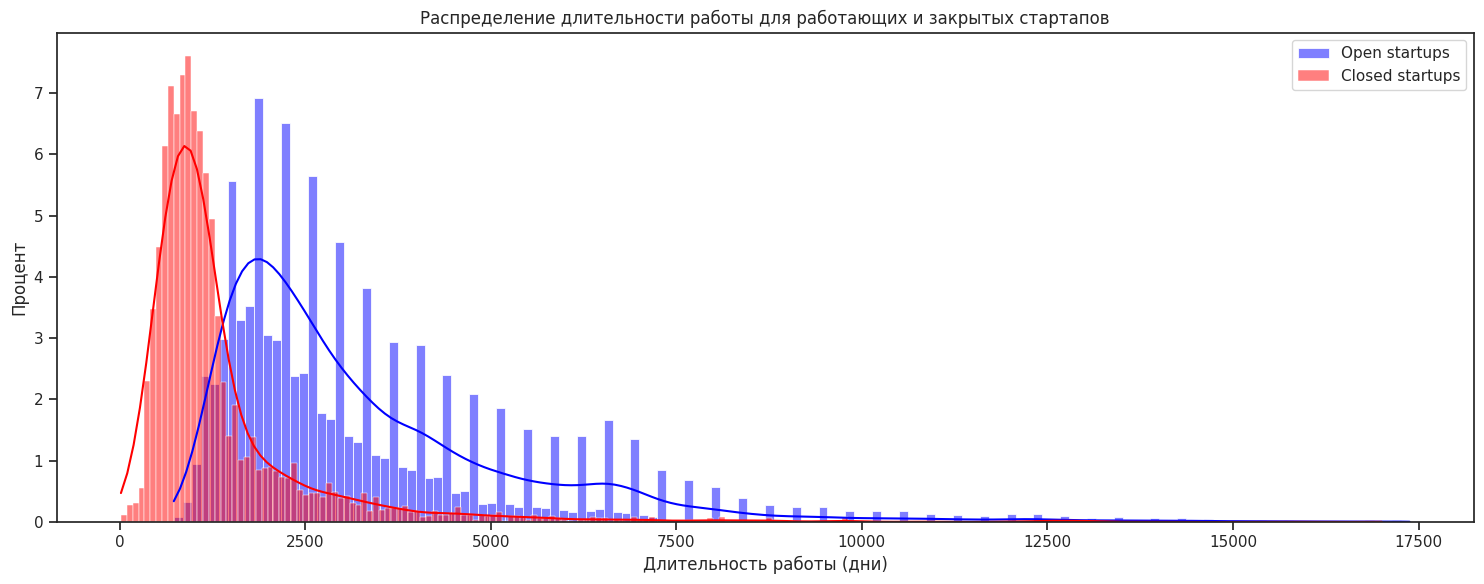

In [41]:
# Анализ длительности работы стартапа
# Разбиваем DataFrame по статусу
open_startups = df_train.query("status == 'operating'")
closed_startups = df_train.query("status == 'closed'")
   
# Строим графики
fig, ax = plt.subplots(figsize=(15, 6))
    
sns.histplot(data=open_startups, x="lifetime", label="Open startups", color="blue", alpha=0.5, kde=True, stat="percent")
sns.histplot(data=closed_startups, x="lifetime", label="Closed startups", color="red", alpha=0.5, kde=True, stat="percent")
    
ax.legend(loc='upper right')
ax.set_xlabel("Длительность работы (дни)")
ax.set_ylabel("Процент")
plt.title('Распределение длительности работы для работающих и закрытых стартапов')
    
plt.tight_layout()
plt.show()

Вывод: средняя длительность работы закрывшихся стартапов составляет около 1000 дней, средняя длительность работы работающих стартапов составляет около 2000 дней.

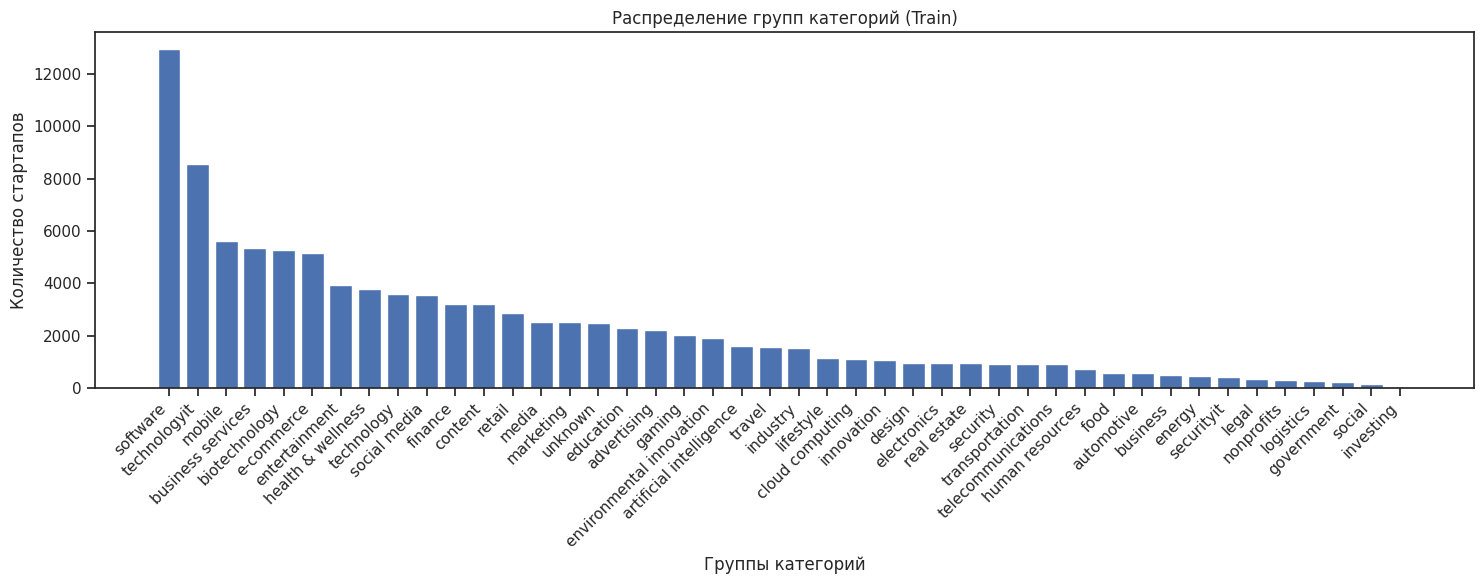

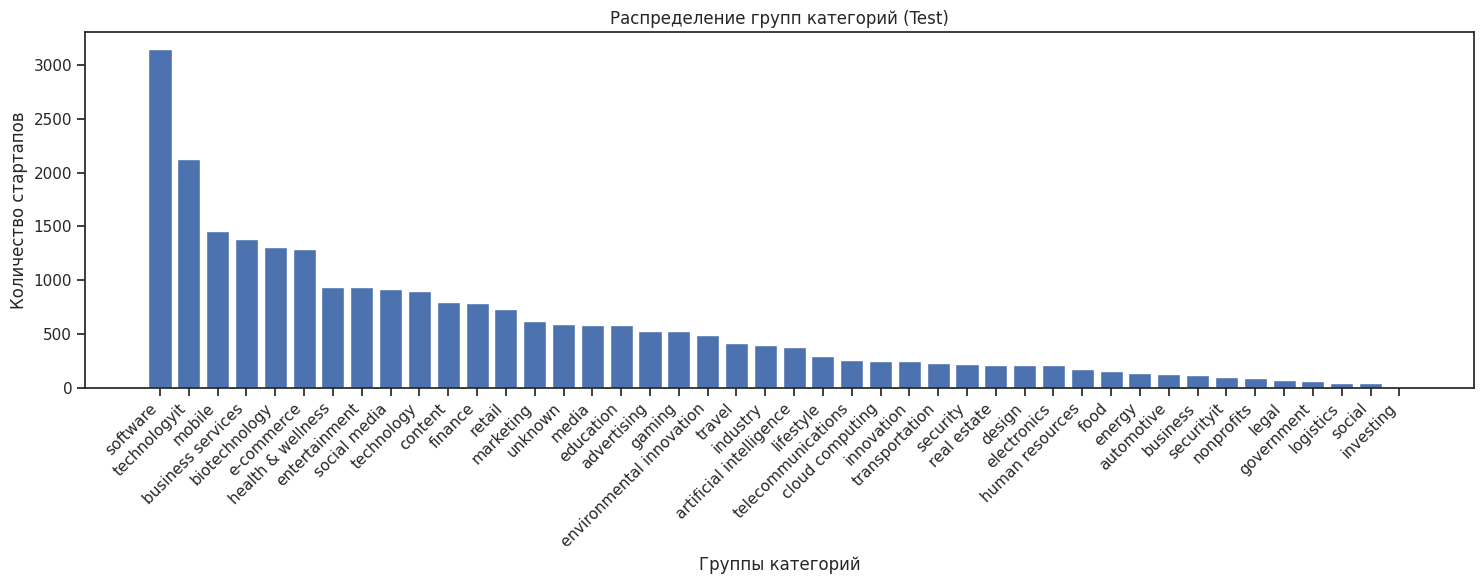

In [42]:
# Распределение выборок по категориям
for df in (df_train, df_test):
    sorted_categories = df[category_list].sum(axis=0).sort_values(ascending=False)
    # Строим диаграмму
    plt.figure(figsize=(15, 6))  # Устанавливаем размер фигуры
    plt.bar(sorted_categories.index, sorted_categories.values)
    plt.title('Распределение групп категорий ' + train_test(df.shape[0]))
    plt.xlabel('Группы категорий')
    plt.ylabel('Количество стартапов')
    plt.xticks(rotation=45, ha='right')  # Поворачиваем подписи осей X для удобства чтения
    plt.tight_layout()  # Улучшаем расположение элементов на графике
    plt.show()


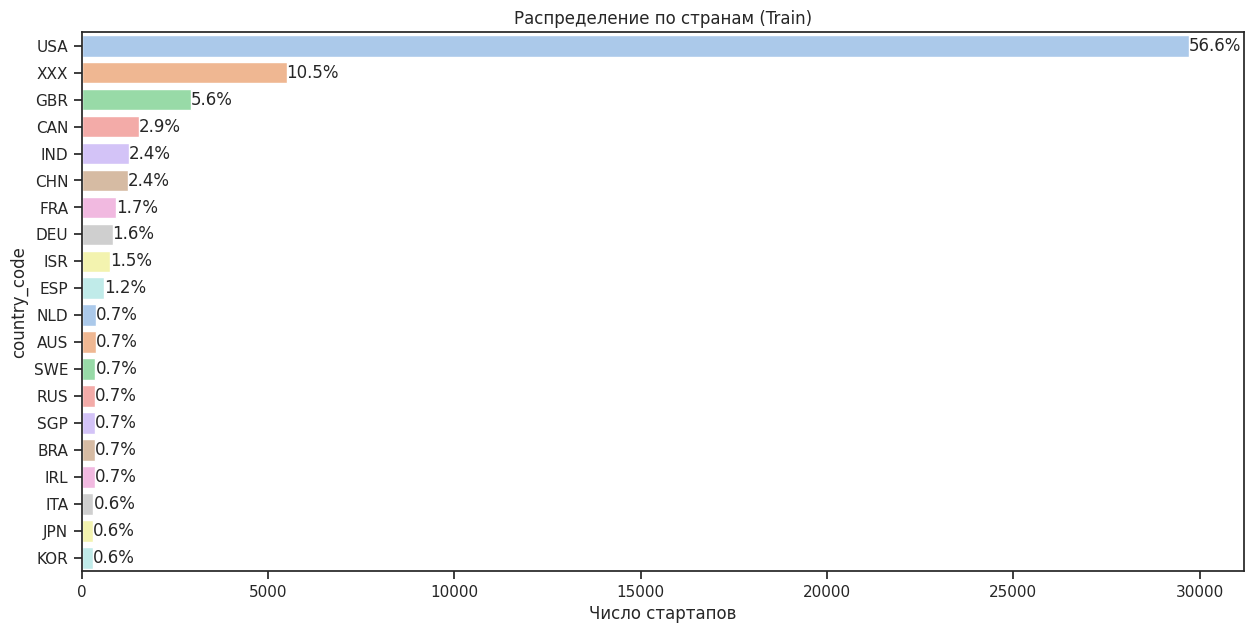

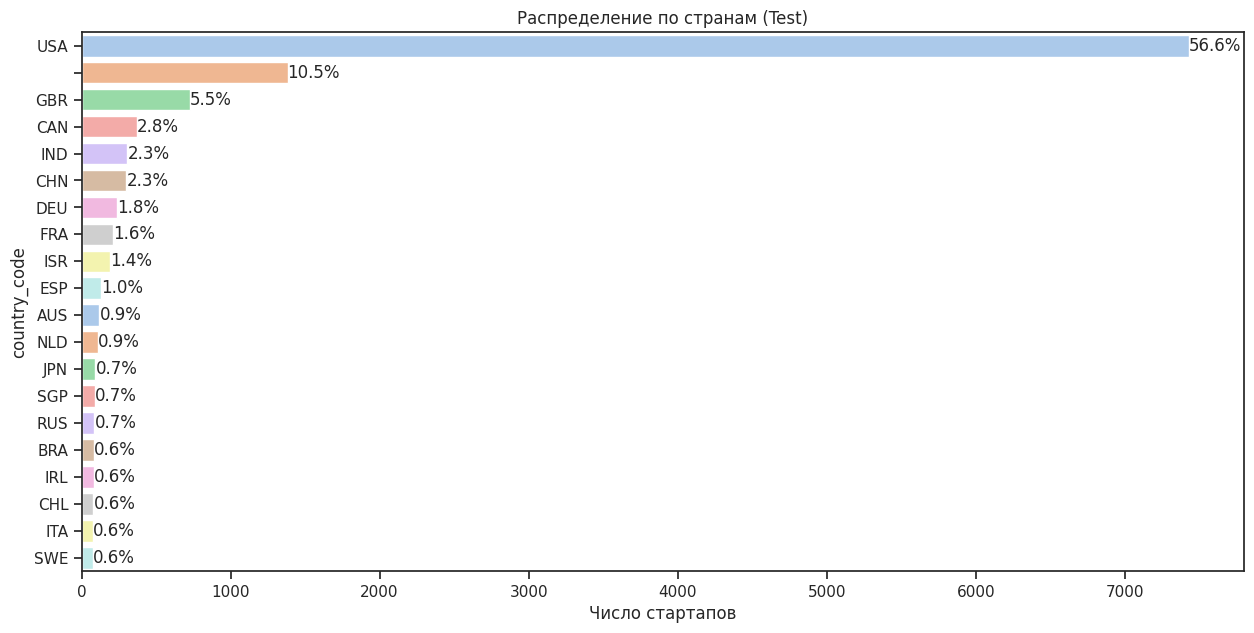

In [43]:
# Распределение выборок по странам
for df in (df_train, df_test):
    #df_train['country_code']
    sorted_categories = df['country_code'].value_counts().index[:20]
    
    plt.figure(figsize=(15, 7)) #df_train['country_code'].unique().size))
    graph_data = sns.countplot(data=df, y='country_code', order=sorted_categories, palette='pastel')
    
    # Получаем общие количество записей
    total_count = len(df)
    
    # Проходимся по всем прямоугольникам на графике и добавляем текстовые аннотации
    for p in graph_data.patches:
        value = p.get_width()
        percentage = f'{100 * value / total_count:.1f}%'  # Рассчитываем процент
        x = p.get_x() + p.get_width() + 0.02  # Смещение текста вправо относительно прямоугольника
        y = p.get_y() + p.get_height() / 2  # Центрируем текст вертикально внутри прямоугольника
        graph_data.text(x=x, y=y, s=percentage, ha='left', va='center')
    
    plt.title('Распределение по странам ' + train_test(df.shape[0]))
    plt.xlabel("Число стартапов")
    plt.show()
    # print(df_train['country_code'].value_counts(normalize=True).round(2));

In [44]:
 display(df_train['funding_total_usd'].dropna().sort_values(ascending=False))

39186    3.007950e+10
21241    1.066494e+10
4557     8.207450e+09
15976    5.820000e+09
36634    5.800000e+09
             ...     
51354    6.000000e+00
29015    5.000000e+00
27332    2.000000e+00
48687    2.000000e+00
11405    1.000000e+00
Name: funding_total_usd, Length: 52516, dtype: float64

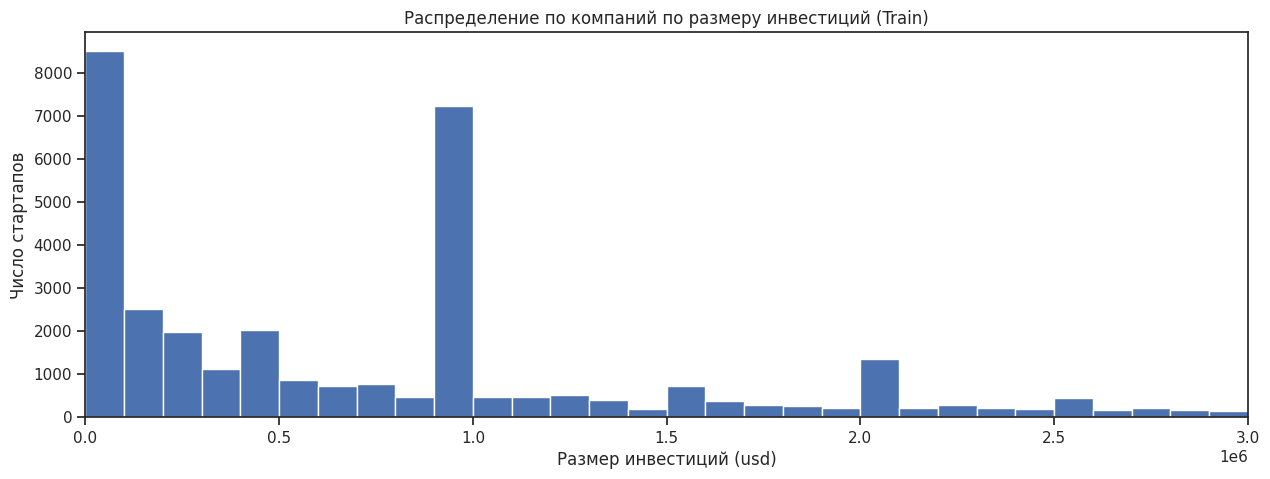

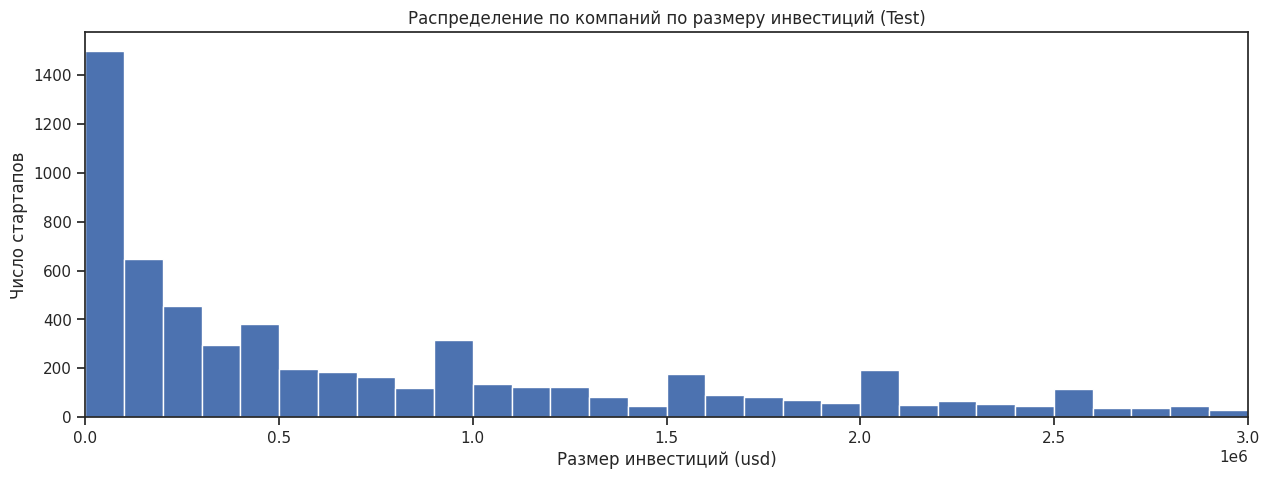

In [45]:
for df in (df_train, df_test):
    limit = 3000000
    plt.figure(figsize=(15,  5))
    plt.xlim(0, limit)
    plt.hist(df['funding_total_usd'][df['funding_total_usd']<limit].dropna().sort_values(ascending=False), bins=30)
    # Показать график
    plt.title('Распределение по компаний по размеру инвестиций ' + train_test(df.shape[0]))
    plt.ylabel("Число стартапов")
    plt.xlabel("Размер инвестиций (usd)")
    plt.show()

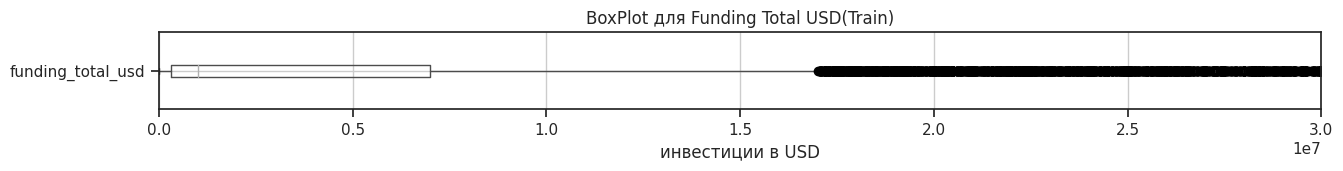

count    5.251600e+04
mean     1.494285e+07
std      1.683632e+08
min      1.000000e+00
25%      3.200000e+05
50%      1.009702e+06
75%      7.000000e+06
max      3.007950e+10
Name: funding_total_usd, dtype: float64

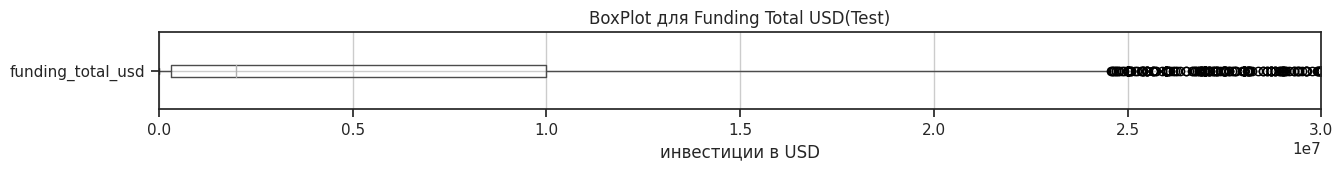

count    1.054700e+04
mean     1.654910e+07
std      9.217283e+07
min      1.000000e+00
25%      3.200000e+05
50%      2.000000e+06
75%      1.000000e+07
max      4.715000e+09
Name: funding_total_usd, dtype: float64

In [46]:
for df in (df_train, df_test):
    # Построение графика распределения
    # Создание коробки с усами
    plt.figure(figsize=(15,  1))
    ax = df.boxplot(column='funding_total_usd', vert=False)

# Настройка графика
    plt.title('BoxPlot для Funding Total USD' + train_test(df.shape[0]))
    plt.xlabel('инвестиции в USD')
    plt.grid(True)
    plt.xlim(0, 30000000)
# Показать график
    plt.show()
    
    display(df['funding_total_usd'].describe())

    
#    ax = df['funding_total_usd'].hist()
#    ax.set_ylabel("Количество")            
#    plt.figure(figsize=(15, 1))
#    bp = plt.boxplot(df['funding_total_usd'], vert=False)
#    outliers = [flier.get_xdata() for flier in bp["fliers"]] # выбросы
#    plt.yticks([1], ["{:>40}".format('funding_total_usd')])
#    plt.show()


## 4 Анализ корреляции признаков

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       52515 non-null  object        
 1   category_list              52516 non-null  object        
 2   funding_total_usd          52516 non-null  float64       
 3   status                     52516 non-null  category      
 4   country_code               52516 non-null  category      
 5   state_code                 52516 non-null  category      
 6   region                     52516 non-null  category      
 7   city                       52516 non-null  category      
 8   funding_rounds             52516 non-null  int64         
 9   founded_at                 52516 non-null  datetime64[ns]
 10  first_funding_at           52516 non-null  datetime64[ns]
 11  last_funding_at            52516 non-null  datetime64[ns]
 12  clos

The number of unique values of variable city is large: 4471. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
The number of unique values of variable region is large: 1037. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
/opt/conda/lib/python3.10/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 1350544. Are interval variables set correctly?
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 4641936. Are interval variables set correctly?
  warnings.warn(
The number of unique values of variable city is large: 4471. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
The number of unique values of variable region is large: 1037. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
/opt/conda/lib/p

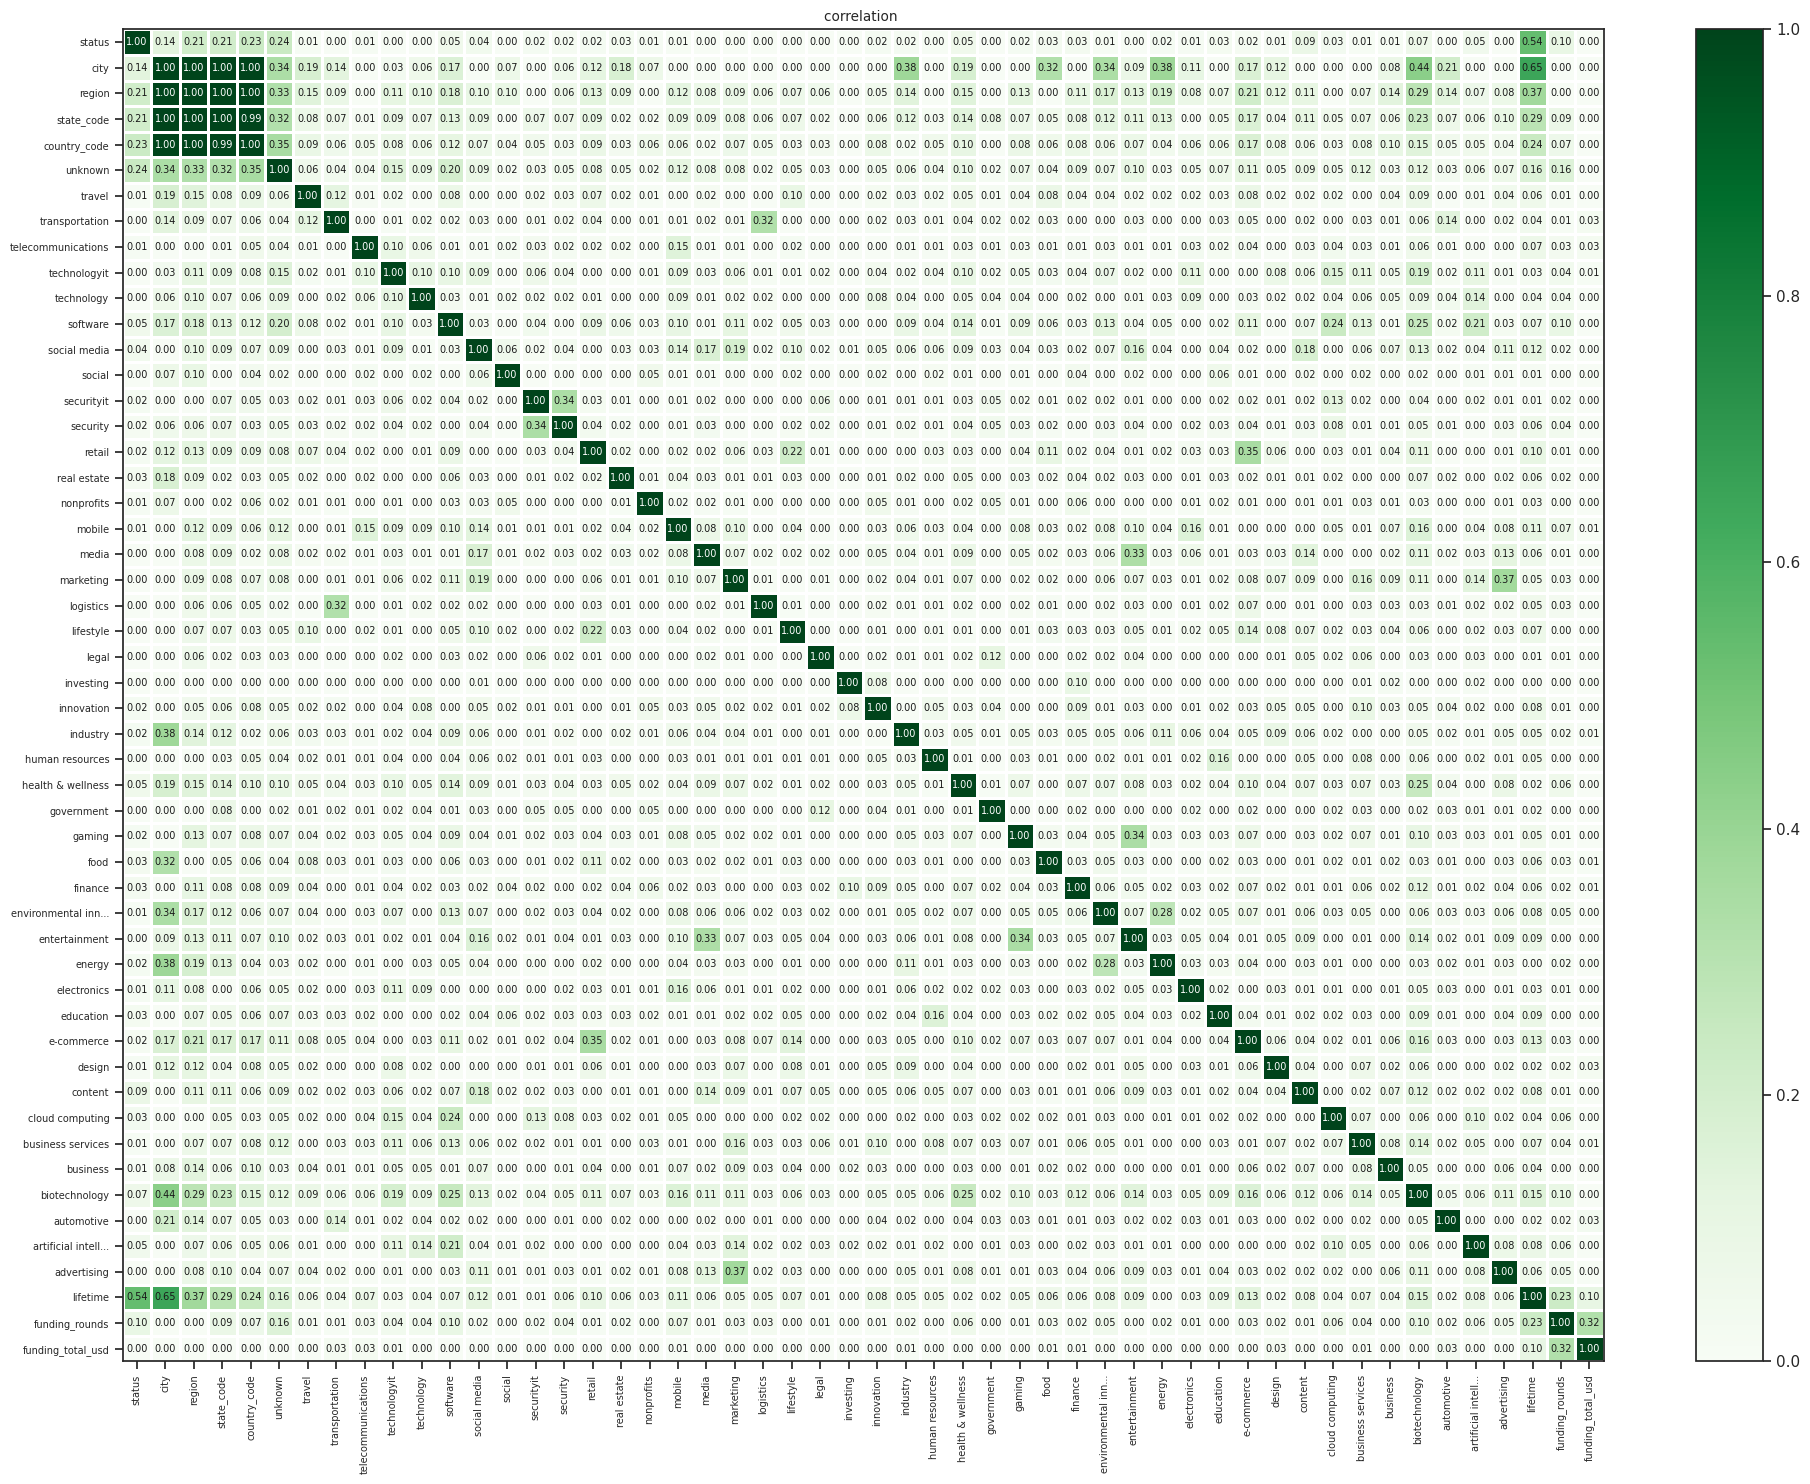

The number of unique values of variable city is large: 2116. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
The number of unique values of variable city is large: 2116. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.


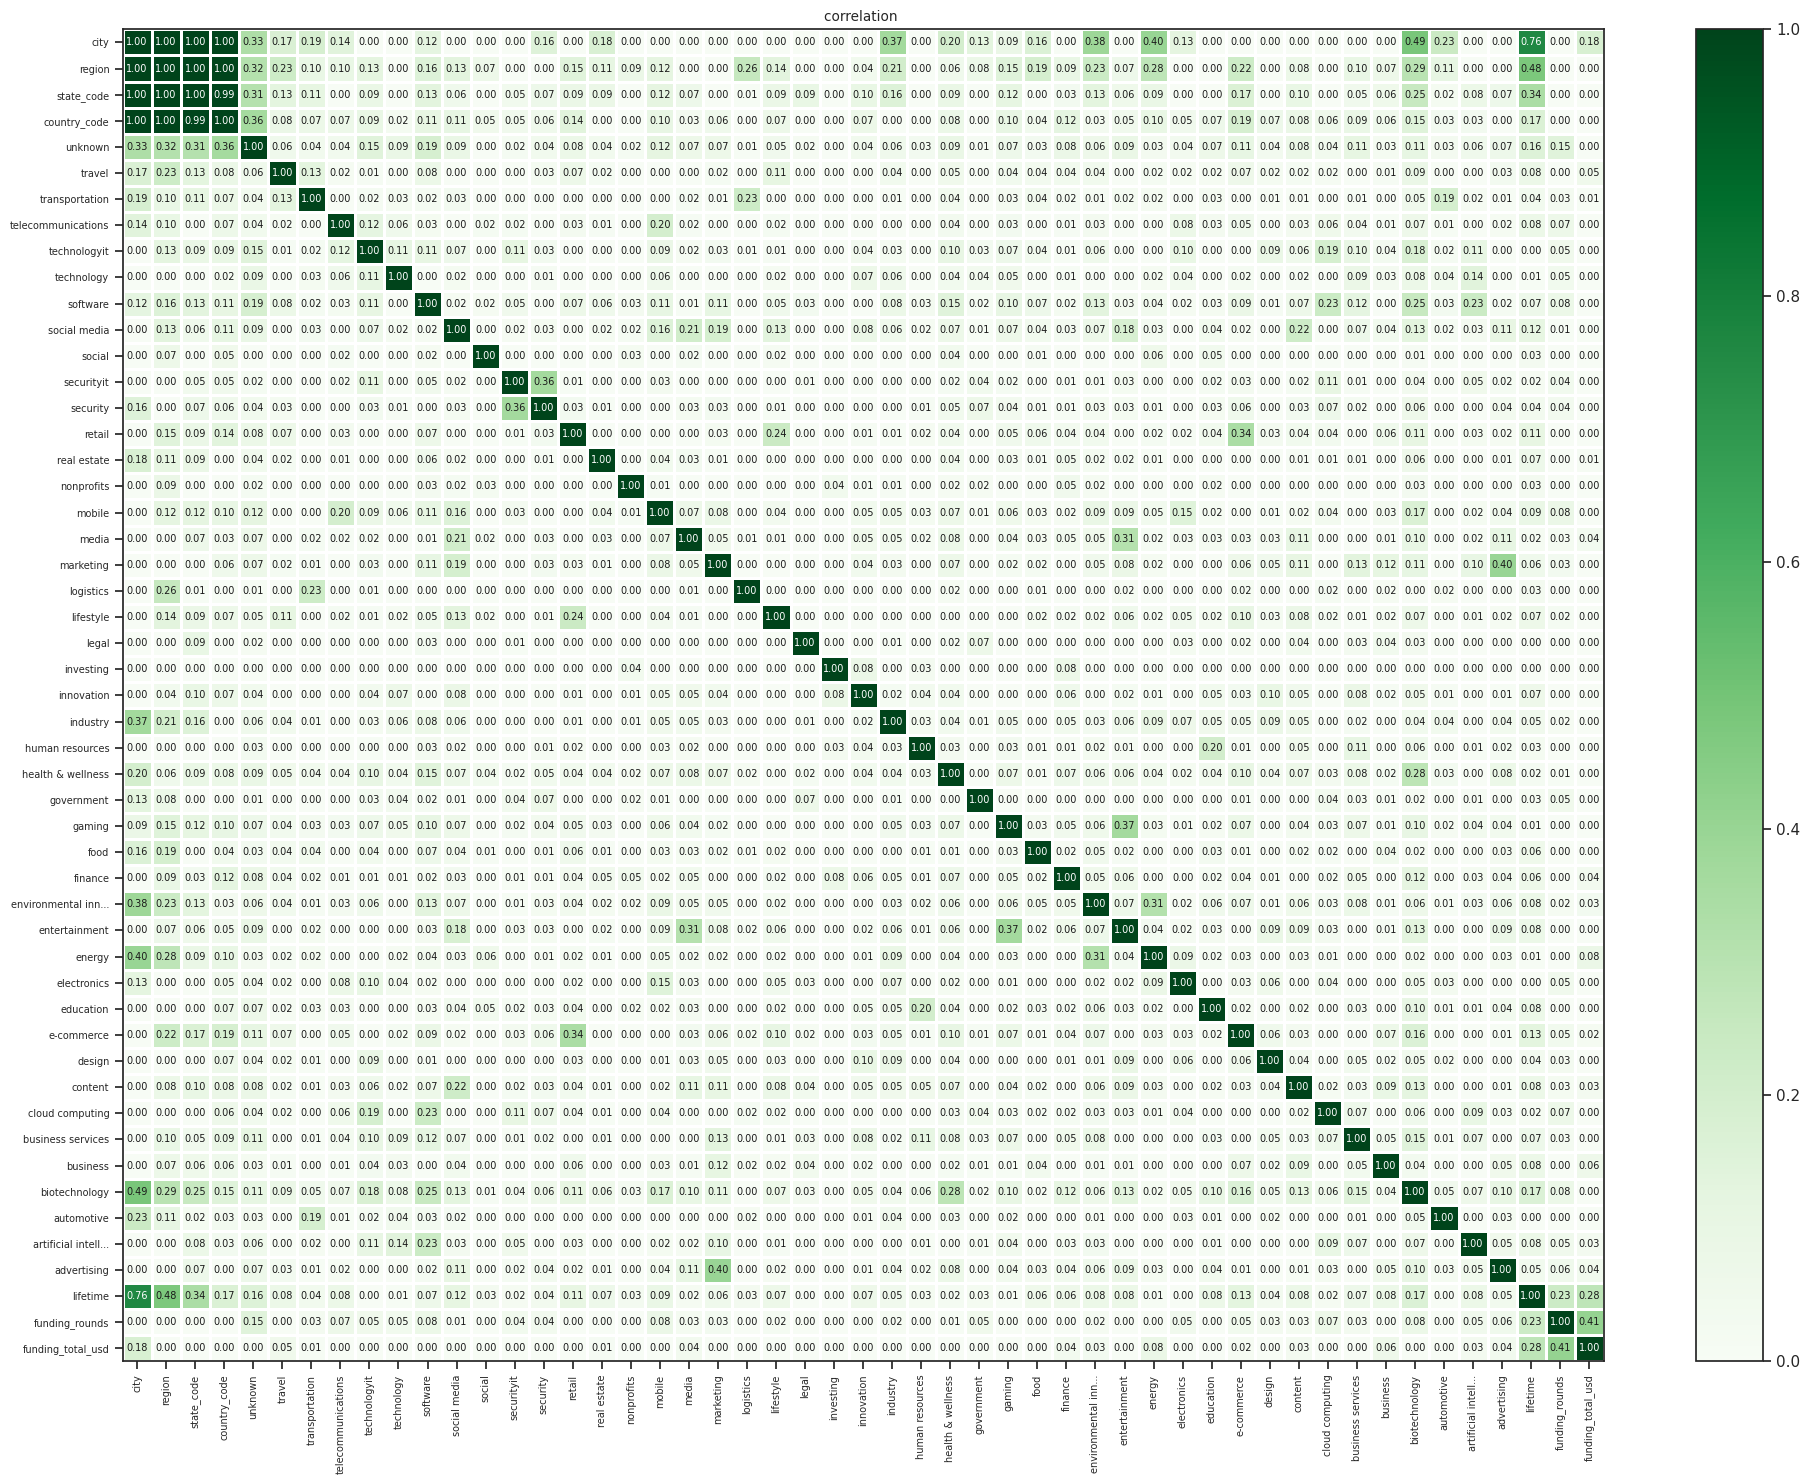

In [49]:
if 2 != 1:
    for df in (df_train, df_test):
        # создаём список с наименованиями непрерывных признаков
        interval_cols = ['funding_total_usd', 'lifetime']
        field_list = ['funding_total_usd', 'funding_rounds', 'lifetime', 'advertising', 'artificial intelligence', 'automotive', 'biotechnology', 'business', 'business services', 'cloud computing', 'content', 'design', 
        'e-commerce', 'education', 'electronics', 'energy', 'entertainment', 'environmental innovation', 'finance', 'food', 'gaming', 'government', 'health & wellness', 'human resources', 'industry', 'innovation', 
        'investing', 'legal', 'lifestyle', 'logistics', 'marketing', 'media', 'mobile', 'nonprofits', 'real estate', 'retail', 'security', 'securityit', 'social', 'social media', 'software', 'technology', 'technologyit', 
        'telecommunications', 'transportation', 'travel', 'unknown', 'country_code', 'state_code',  'region', 'city']
        if train_test(df.shape[0]) == '(Train)':
            field_list.append('status')
    #    print(field_list)
        # Рассчитываем матрицу phik
    #    df_phik = df[['funding_total_usd', 'funding_rounds', 'lifetime']]
        df_phik = df[field_list]
    #    df_phik.info()
        phik_corr = phik_matrix(df_phik, interval_cols=interval_cols)
    
        # Отображаем результаты
        #print(phik_corr)
    
        # считаем корреляции на тренировочной выборке
        phik_overview = phik_matrix(df_phik, interval_cols=interval_cols)
    
        plot_correlation_matrix(
            phik_overview.values,
            x_labels=phik_overview.columns,
            #y_labels=phik_overview.columns,
            y_labels=phik_overview.index,
            vmin=0, 
            vmax=1, 
            color_map='Greens',
            title='correlation ',
            fontsize_factor=0.7,
            figsize=(20, 15)
        ) 
        plt.show()

Существует фактически полная корреляция полей локации (country_code, state_code, region, city), поэтому планируется использовать комбинацию этих полей, т.к. в случае объединении этих полей локация стартапа будет описана наиболее точно.

In [50]:
# Анализ зависимости полей дат
# 'first_funding_at_y', 'first_funding_at_m', 'first_funding_at_d', 'last_funding_at_y', 'last_funding_at_m', 'last_funding_at_d', 'after_last_invest', 'investtime'

columns_to_correlate = [
    'first_funding_at_y',
    'first_funding_at_m',
    'first_funding_at_d',
    'last_funding_at_y',
    'last_funding_at_m',
    'last_funding_at_d',
    'after_last_invest',
    'investtime',
    'lifetime'
]

correlation_matrix = df_test[columns_to_correlate].corr()
print(correlation_matrix)

#interval_cols = ['first_funding_at_y', 'first_funding_at_m', 'first_funding_at_d', 
#                 'last_funding_at_y', 'last_funding_at_m', 'last_funding_at_d', 
#                 'after_last_invest', 'investtime', 'lifetime']

#corr_matrix = df_test.phik_matrix(interval_cols= interval_cols)


#plt.figure(figsize=(15, 12))
#sns.heatmap(corr_matrix, annot=True, cmap='Greens')
#plt.title('Корреляционная матрица')
#plt.show()

                    first_funding_at_y  first_funding_at_m  \
first_funding_at_y            1.000000            0.009624   
first_funding_at_m            0.009624            1.000000   
first_funding_at_d            0.058593            0.082815   
last_funding_at_y             1.000000            0.009624   
last_funding_at_m             0.009624            1.000000   
last_funding_at_d             0.058593            0.082815   
after_last_invest            -0.996272           -0.095499   
investtime                    0.119409            0.020098   
lifetime                     -0.418076           -0.012865   

                    first_funding_at_d  last_funding_at_y  last_funding_at_m  \
first_funding_at_y            0.058593           1.000000           0.009624   
first_funding_at_m            0.082815           0.009624           1.000000   
first_funding_at_d            1.000000           0.058593           0.082815   
last_funding_at_y             0.058593           1.000000  

Даты первого и последнего раунда инвестирования сильно коррелируют между собой, а также с периодом между последним раундом инвестирования и закрытием стартапа.
Поэтому для прогноза о закрытии используем признаки: 'lifetime', 'investtime', 'last_funding_at_y', 'last_funding_at_m', 'last_funding_at_d'

In [51]:
# функция для вывода информации о датафрейме
def df_visualise (df, cat_cols=False, qnt_cols=False, rem_outliers = '-------', df_name=''):
    print(start_high + df_name + end_high)
    if len(cat_cols) > 0:
        print('\n' + start_high + 'Категорийные поля' + end_high)
        for i in cat_cols:
            plt.figure(figsize=(15,  df[i].unique().size))
            graph_data = sns.countplot(data=df, y=i, palette='pastel')
            plt.xlabel("Число стартапов")
            plt.show()
            print(df[i].value_counts(normalize=True).round(2));
    if len(qnt_cols) > 0:
        print('\n' + start_high + 'Количественные поля' + end_high)
        k = -1
        for i in qnt_cols:
            k += 1
            ax = df[i].hist()
            ax.set_ylabel("Количество")            
            plt.figure(figsize=(15, 1))
            bp = plt.boxplot(df[i], vert=False)
            outliers = [flier.get_xdata() for flier in bp["fliers"]] # выбросы
            plt.yticks([1], ["{:>40}".format(i)])
            plt.show()
            if len(outliers[0]) > 0 and rem_outliers[k] == '+': # удаление выбросов
                for j in outliers[0]:
                    # print(j)
                    df = df[df[i] != j]
                print(i, " ящик с усами после удаления выбросов")
                plt.figure(figsize=(15, 1)) # печать ящика с усами после удаления выбросов
                plt.boxplot(df[i], vert=False)
                plt.yticks([1], ["{:>40}".format(i)])
#                plt.ylabel(di[i]) 
                plt.show()
    return df

In [53]:
#print(df_train__cat_cols)
#df_train__cat_cols.pop(1)
#print(df_train__cat_cols)


## 5 Подготовка данных и обучение моделей

### Подготовка пайплайна

In [54]:
# Делим выборку на features и target
y_train = df_train.status
X_train = df_train.drop(['status'], axis = 1)


In [55]:
# Разделение данных на тренировочную и тестовую (из тренировочных данных) выборки
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_train)

In [56]:
if 1 != 1:
    # Построение графика
    plt.figure(figsize=(15, 6))
    # Группировка данных по 'country_code' и вычисление среднего значения 'funding_total_usd'
    grouped_data = df_train.groupby('country_code')['funding_total_usd'].mean().reset_index()
    
    display(grouped_data)
    
    # Построение графика
    sns.barplot(x='country_code', y='funding_total_usd', data=grouped_data)
    plt.xlabel('Country Code')
    plt.ylabel('Average Funding Total USD')
    plt.title('Average Funding Total USD by Country Code')
    plt.show()

In [57]:
# Признаки для pipeline
# Коэффициенты: [5938 6516  867 8882 2711 3351 3801 4479  290  400  298  228  288  303 216  464  391]
# Коэффициенты: [6243 6822  761 9010 2633 3325 3638 4266  360  420  373
ord_cols = ['country_state_region_city']     #['city'] #ready
num_cols = ['funding_total_usd', 'funding_rounds', 
            'lifetime', 'investtime', 'last_funding_at_y', 'last_funding_at_m', 'last_funding_at_d',
            #'biotechnology', 
            'business services', 
            #'e-commerce', 'finance', 'health & wellness', 'mobile','social media',
            'software','technologyit'
#            'advertising', 'artificial intelligence', 'automotive', 'biotechnology', 
#            'business', 'business services', 'cloud computing', 'content', 'design', 'e-commerce', 'education', 'electronics', 'energy', 
#            'entertainment', 'environmental innovation', 'finance', 'food', 'gaming', 'government', 'health & wellness', 'human resources', 
#            'industry', 'innovation', 'investing', 'legal', 'lifestyle', 'logistics', 'marketing', 'media', 'mobile', 'nonprofits', 'real estate', 
#            'retail', 'security', 'securityit', 'social', 'social media', 'software', 'technology', 'technologyit', 'telecommunications', 
#            'transportation', 'travel' 
           ]

# Код ниже использовался для подборки признаков для модели
if 1 != 1:
    cols = ord_cols + num_cols
    
    coefficients = [4843, 5145,  785, 7112, 2241, 2867, 2985, 3620,  113,   86,   50,  232,   50,  324,
       78,  138,  110,  239,  149,   80,   47,  179,  152,  204,   78,  167,   27,  250,
       41,  140,   60,    0,   38,   85,   22,  150,  179,  241,   76,   73,  184,   72,
       53,   22,  213,  374,  182,  331,  105,  107,  110]
    
    df_coef = pd.DataFrame({
        'cols': cols,
        'coefficients': coefficients
    })
    
    df_coef.head(60)

In [58]:
# создадим экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучение модели и трансформация тестовой выборки
y_train_train_coded = label_encoder.fit_transform(y_train_train)
y_train_test_coded = label_encoder.transform(y_train_test)

# Проверка код-значение
print(label_encoder.inverse_transform([0, 1])) 

['closed' 'operating']


In [59]:
# ======================================== OE ============================================== # 
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# ======================================== preprocessor ===================================== # 

data_preprocessor = ColumnTransformer(
    [
#        ('ohe', ohe_pipe, cat_cols),
        ('ord', ord_pipe, ord_cols), #ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
#    remainder='passthrough'
) 

# ======================= итоговый пайплайн: подготовка данных и модель ====================== # 

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression())
    ]
) 

pipe_prep = Pipeline(
    [
        ('preprocessor', data_preprocessor),
    ]
) 

In [60]:
# Параметры для pipeline
# Модель тестировалась на нескольких типах моделей.
# Была выбрана LGBMClassifier, остальные закомментарены для экономии ресурсов во время подборки параметров для LGBMClassifier

param_grid = [

    {
        'models': [LGBMClassifier(max_depth = 6, is_unbalance = True, objective = 'binary', #max_depth = 6
                                  verbose=-1, force_row_wise=True, reg_alpha=0.1, reg_lambda=1.0, #reg_alpha=0.1, reg_lambda=1.0, 
                                min_child_samples = 30, num_leaves = 35, bagging_freq = 2)],
        'models__n_estimators': (1100, 1200), #(1180, 1200), #1183
 #       'models__max_depth': (5, 6), #6
 #       'models__min_child_samples': (16, 22), #19
 #       'models__num_leaves': (33, 35), #35
#        'models__reg_alpha': (0, 10),
#        'models__reg_lambda': (0, 10),
        'models__feature_fraction': (0.6, 0.7), #(0.65, 0.7), #0.61
        'models__bagging_fraction': (0.75, 0.8), # 0.8
 #       'models__bagging_freq': (1, 3), #2
        'models__learning_rate': (0.095, 0.1), #(0.095, 0.1), #0.1
#        'models__num_leaves': [21, 31, 41, 51],
#        'models__feature_fraction':[0.5, 0.9], #, 'linear','poly', ],  
        
        
#        'preprocessor__ohe': [ohe_pipe],  
#        'preprocessor__ord': [ord_pipe], #, ohe_pipe],  
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },

#    {
#        'models': [CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, cat_features=ord_cols, verbose=50)],        
#    },
#    {
#        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
#        'models__C': [7, 10],
#        'models__kernel':['rbf'], #, 'linear','poly', ],  
#        'preprocessor__ohe': [ohe_pipe],  
#        'preprocessor__ord': [ord_pipe], #, ohe_pipe],  
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
#    },

    
    # словарь для модели DecisionTreeClassifier()
#    {
#        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
#        'models__max_depth': range(2, 10),
#        'models__min_samples_split': range(13, 14),
#        'models__max_features': range(5, 6),
#        'preprocessor__ohe': [ohe_pipe],  
#        'preprocessor__ord': [ord_pipe], #ohe_pipe],  
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
#    },
    
    # словарь для модели RandomForestClassifier()
 #   {
 #       'models': [RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)],
 #       'models__n_estimators': range(100, 200),
 #       'models__max_depth': range(2, 10),
 #       'models__max_features': range(3, 5),
 #       'models__min_samples_leaf': range(1, 10),
 #       'models__min_samples_split': range(2, 10),
 #       'preprocessor__ohe': [ohe_pipe],  
 #       'preprocessor__ord': [ord_pipe], #ohe_pipe],  
 #       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
 #   },
    # словарь для модели KNeighborsClassifier()
 #   {
 #       'models': [KNeighborsClassifier()],
 #       'models__n_neighbors': range(2, 10),
#        'preprocessor__ohe': [ohe_pipe],  
 #       'preprocessor__ord': [ord_pipe], #, ohe_pipe],  
 #       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
 #   },

    # словарь для модели LogisticRegression()
##    {
##        'models': [LogisticRegression(
##            random_state=RANDOM_STATE, 
##            solver='liblinear',
#            C = 1,
#            penalty='l2'
#        )],
##        'models__C': range(1, 3),
##        'models__penalty': ['l1', 'l2'],
##        'preprocessor__ohe': [ohe_pipe],  
##        'preprocessor__ord': [ord_pipe], # ohe_pipe],  
##        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
##    },
 
]

Была выбрана байесовская оптимизация, как компромис между качеством (GridSearchCV) и скоростью (RandomizedSearchCV)

In [61]:

# Настройка Байесовской оптимизации
bayes_cv_tuner = BayesSearchCV(
    estimator=pipe_final,
    search_spaces=param_grid,
    n_iter=32,  # Число итераций Байесовской оптимизации
    scoring='f1',  # Метрика для оценки качества модели
    cv=5,  # Кросс-валидация
    n_jobs=-1,  # Использование всех ядер CPU
    verbose=-1,  # Уровень вывода информации
    refit=True,  # Переподгонка лучшей модели на весь тренировочный набор
    random_state=42
)

# Запуск процесса оптимизации
result = bayes_cv_tuner.fit(X_train_train, y_train_train_coded)



In [62]:
# Получение лучших параметров
best_params = result.best_params_
print("Лучшие параметры:", best_params)

# Оценка производительности на тестовом наборе
best_classifier = result.best_estimator_

# Извлечение коэффициентов
coefficients = result.best_estimator_.named_steps['models'].feature_importances_

# Вывод коэффициентов
print("Коэффициенты:", coefficients)

test_accuracy = best_classifier.score(X_train_test, y_train_test_coded)
print("Точность на тестовом наборе:", test_accuracy)

Лучшие параметры: OrderedDict([('models', LGBMClassifier(bagging_fraction=0.7863862871588663, bagging_freq=2,
               feature_fraction=0.6932867998847834, force_row_wise=True,
               is_unbalance=True, learning_rate=0.09657899796743524,
               max_depth=6, min_child_samples=30, n_estimators=1167,
               num_leaves=35, objective='binary', reg_alpha=0.1, reg_lambda=1.0,
               verbose=-1)), ('models__bagging_fraction', 0.7863862871588663), ('models__feature_fraction', 0.6932867998847834), ('models__learning_rate', 0.09657899796743524), ('models__n_estimators', 1167)])
Коэффициенты: [6243 6822  761 9010 2633 3325 3638 4266  360  420  373]
Точность на тестовом наборе: 0.9756283320639756


## 6. Анализ важности признаков

In [63]:
result.best_estimator_.named_steps['models'].feature_importances_[0]
best_classifier = result.best_estimator_
coefficients = best_classifier.named_steps['models'].feature_importances_

print(coefficients)

[6243 6822  761 9010 2633 3325 3638 4266  360  420  373]


Коэффициенты: [6243 6822  761 9010 2633 3325 3638 4266  360  420  373] Точность на тестовом наборе: 0.9756283320639756 9

Коэффициенты: [2139 2440  368 3223 1201 1463 1297 1430  115  165  102] Точность на тестовом наборе: 0.9691546077684692 8

Коэффициенты: [6623 7173  831 9209 2777 3540 3701 4383  384  460  391] Точность на тестовом наборе: 0.9744859101294745 7

Коэффициенты: [6318 7295  826 9091 2702 3426 3713 4490  379  450  402] Точность на тестовом наборе: 0.9754379284082254 6

In [64]:
#best_classifier.named_steps['models'].get_feature_names()

In [70]:
if 2 != 1:
    test_accuracy = bayes_cv_tuner.score(X_train_test, y_train_test_coded)
    print("Точность на тестовом наборе:", test_accuracy)
    
    # Извлечение важности признаков
    feature_importances = pd.DataFrame({
        'feature': ['country_state_region_city', 'funding_total_usd', 'funding_rounds', 
            'lifetime', 'investtime', 'last_funding_at_y', 'last_funding_at_m', 'last_funding_at_d',
            'business services', 'software','technologyit'], 
        'importance': coefficients,
    })
    
    # Сортировка по убыванию важности
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
    # Вывод первых 10 самых важных признаков
    print("\nСамые важные признаки:")
    print(feature_importances)


Точность на тестовом наборе: 0.9865982619620981

Самые важные признаки:
                      feature  importance
3                    lifetime        9010
1           funding_total_usd        6822
0   country_state_region_city        6243
7           last_funding_at_d        4266
6           last_funding_at_m        3638
5           last_funding_at_y        3325
4                  investtime        2633
2              funding_rounds         761
9                    software         420
10               technologyit         373
8           business services         360


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


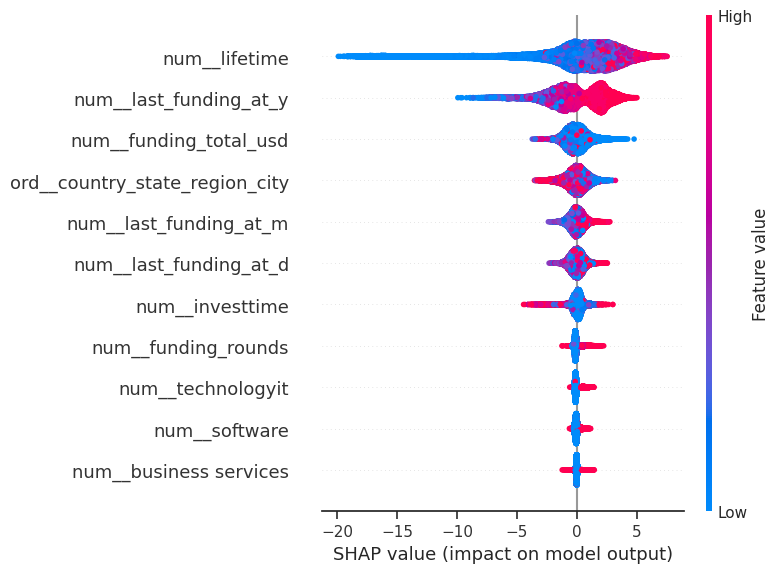

In [73]:
if 2 != 1:
    model = result.best_estimator_.named_steps['models']
    
    X_encoded = bayes_cv_tuner.best_estimator_['preprocessor'].transform(X_train)
    
    # Use TreeExplainer for RandomForestClassifier
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_encoded)
    
    # Using shap.summary_plot to visualize feature importance
    encoder_col_names = bayes_cv_tuner.best_estimator_['preprocessor'].get_feature_names_out()
    shap.summary_plot(shap_values[1], features=X_encoded, feature_names=encoder_col_names, max_display=40)

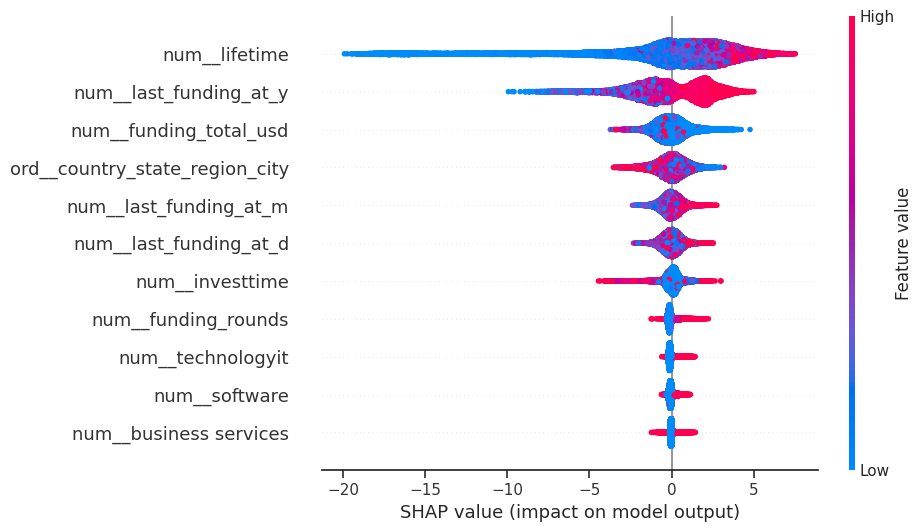

In [74]:
if 2 != 1:
    # Convert to Explanation object for the positive class (e.g., class 1) 
    shap_values_exp = shap.Explanation( 
        values=shap_values[1],  # SHAP values for the positive class 
        base_values=explainer.expected_value[1],  # Base value for the positive class 
        data=X_encoded,  # Encoded input data 
        feature_names=encoder_col_names  # Feature names 
    ) 
        
    # Beeswarm plot 
    shap.plots.beeswarm(shap_values_exp, max_display=20)

    

## 7. Прогноз на тестовых данных и экспорт результатов

In [75]:
# Предсказание на валидационной выборке
y_train_test_pred = bayes_cv_tuner.predict(X_train_test)
print(start_high,f'f1: {f1_score(y_train_test_coded, y_train_test_pred):.2}', end_high)



  f1: 0.99  



In [76]:
# Предсказание на валидационной выборке
y_test_pred = bayes_cv_tuner.predict(df_test)

In [77]:
# Объединение предсказания и исходных данных
df_test_final = pd.concat([df_test, pd.DataFrame(y_test_pred, columns=['pred'])], axis=1)

In [78]:
# Выгрузка результата работы
df_test_final['status'] = 'operating'
df_test_final.loc[df_test_final['pred'] == 0, 'status'] = 'closed'
df_test_final[['name', 'status']]
df_test_final[['name', 'status']].to_csv('startups_operations-close_predictions.csv', sep=',', index=False)

## 8. Выводы

* Наибольшее влияние на вероятность закрытия стартапа оказывает длительность работы: чем дольше работает стартап, тем вероятность закрытия меньше.
* Кроме того, сильное влияние оказывает географическая локация (страна-штат-регион-город) и размер инвестиций.
* Среднее влияние оказывают время инвестиций (начало, окончание, длительность)
* Слабое влияние на вероятность закрытия оказывает направление деятельности стартапа. Самое сильное влияние оказывают направления 'business services', 'software','technologyit'.

